In [1]:
import sys
sys.path.append("./")
import numpy as np
import pandas as pd
import networkx as nx
import scipy.sparse
import collections
from collections import Counter, defaultdict
import json
import svd_new
from toolKit import load_graph
from matlab import engine
from itertools import combinations
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pyod.models.feature_bagging import FeatureBagging
import random

In [2]:
eng = engine.start_matlab()

In [3]:
repos_root = "../data"

### 1. Load data

In [4]:
giver_2_claimer, claimer_2_giver = load_graph("%s/RawData/giver_claimer.graph"%repos_root) # bipartite graph.
num_cid = len(set(giver_2_claimer).union(set(claimer_2_giver)))

In [5]:
num_cid, len(claimer_2_giver)

(2490958, 1516956)

In [6]:
with open('%s/SuspiciousCustomers/Ground_truth_cusIdx_to_label_717.json'%repos_root, "r") as fp:
    cusIdx2Labels = json.load(fp)

In [7]:
idx_2_cid = {}
cid_2_idx = {}
with open('%s/RawData/idx_to_cid_mapping_wtgraph.txt'%repos_root, 'r') as f:
    for line in f.readlines():
        idx, cid = line.strip().split(" ")
        idx_2_cid[int(idx)] = int(cid)
        cid_2_idx[int(cid)] = int(idx)

In [8]:
mat_binary = svd_new.load_matrix('%s/RawData/giver_claimer_wtgraph_binary.txt'%repos_root, shape=(num_cid, num_cid)).astype(int)
G_binary = nx.from_scipy_sparse_matrix(mat_binary, create_using=nx.DiGraph(), edge_attribute='binary')

mat_raw_count = svd_new.load_matrix('%s/RawData/giver_claimer_wtgraph_raw_count.txt'%repos_root, shape=(num_cid, num_cid))
G_raw_count = nx.from_scipy_sparse_matrix(mat_raw_count, create_using=nx.DiGraph(), edge_attribute='raw_count')

mat_denomination = svd_new.load_matrix('%s/RawData/giver_claimer_wtgraph_raw_denomination.txt'%repos_root, shape=(num_cid, num_cid))
G_denomination = nx.from_scipy_sparse_matrix(mat_denomination, create_using=nx.DiGraph(), edge_attribute='denomination')

In [9]:
scipy.sparse.save_npz('%s/BasicMetricData/mat_binary.npz'%repos_root, mat_binary)
scipy.sparse.save_npz('%s/BasicMetricData/mat_raw_count.npz'%repos_root, mat_raw_count)
scipy.sparse.save_npz('%s/BasicMetricData/mat_denomination.npz'%repos_root, mat_denomination)

### 2. Feature metrics

###### 2.1 indegree

In [10]:
indegree_distr, indegree_rawCount_distr, indegree_denomi_distr, claimers = [],[],[],[]
for _claimer in claimer_2_giver.keys():
    _indegree, _indegree_rawCount, _indegree_denomi = G_binary.in_degree(_claimer), \
                                                        G_raw_count.in_degree(_claimer, weight="raw_count"), \
                                                          G_denomination.in_degree(_claimer, weight="denomination")
    indegree_distr.append(_indegree)
    indegree_rawCount_distr.append(_indegree_rawCount)
    indegree_denomi_distr.append(_indegree_denomi)
    claimers.append(_claimer)

###### 2.2 outdegree

In [11]:
outdegree_distr, outdegree_rawCount_distr, outdegree_denomi_distr, givers = [],[],[],[]
for _giver in giver_2_claimer.keys():
    _outdegree, _outdegree_rawCount, _outdegree_denomi = G_binary.out_degree(_giver), \
                                                            G_raw_count.out_degree(_giver, weight="raw_count"), \
                                                                G_denomination.out_degree(_giver, weight="denomination")
    outdegree_distr.append(_outdegree)
    outdegree_rawCount_distr.append(_outdegree_rawCount)
    outdegree_denomi_distr.append(_outdegree_denomi)
    givers.append(_giver)

### 2. Functions

In [12]:
def draw_distr_log(x, y, x_abn, metric_name):

    fig = plt.figure()
    fig.patch.set_facecolor('w')
    x_log = np.log2(x)
    y_log = np.log2(y)
    f = np.polyfit(x_log,y_log,4)
    y_log_hat = [f[0]*_x*_x*_x*_x + f[1]*_x *_x*_x + f[2]*_x*_x + f[3]*_x + f[4] for _x in x_log]
#     p1, = plt.plot(x_log, y_log, "-ob")
#     p2, = plt.plot(x_log, y_log_hat,"-or")
    p1, = plt.plot(x_log, y_log, "ob", markersize=5)
    p2, = plt.plot(x_log, y_log_hat,"-or", markersize=5)
    
#     for i in np.log2(x_abn):
#         plt.axvline(x=i)
    
    plt.xlabel("%s"%metric_name)
    plt.ylabel("Frequency (log)")
    leg = plt.legend([p1, p2], ['Data', 'Fitted curve'], loc=1, bbox_to_anchor=(1, 1), borderaxespad=0.)
    leg.draw_frame(False)
    plt.savefig('./caseStudy/%s.png'%metric_name, dpi=1000)
    plt.show()

##### 2.1 logSpike

In [13]:
def logSpikeFilter(X, Cs, metric, perc_Ys_dev, perc_Xs):

    """
    Output the suspicious customer set.
    Parameters:
        X: the value list of this specific metric for each customer.
        Cs: the corresponding customer list.
    Returns: 
        Suspicious customers released by the model.
    """

    if metric == "outdegree_denomination":
        _round_X = np.round(X).astype(int)+1
        _counter = dict(Counter(_round_X))
    else:
        _counter = dict(Counter(X))
    _ux = np.array(list(_counter.keys()))
    _y = np.array(list(_counter.values()))

    x = np.log2(_ux)
    y = np.log2(_y)
    
    f = np.polyfit(x,y,4)
    y_hat = [f[0]*_x*_x*_x*_x + f[1]*_x *_x*_x + f[2]*_x*_x + f[3]*_x + f[4] for _x in x]

    dev_fit = np.abs(y - y_hat)
    dev_thrld = np.percentile(dev_fit, perc_Ys_dev)
    sus_set = _ux[dev_fit >= dev_thrld]
    
    _sus_score = dev_fit/np.linalg.norm(dev_fit).astype(float)
    ux_2_susScore = dict(zip(_ux, _sus_score))
    
    thrld = np.percentile(X, perc_Xs)
    
    sus_customers_dict = defaultdict(list)
    suspicous_score_X = {}

    for _metric, _idx in zip(X, Cs):
        if _metric in sus_set and _metric > thrld:
            sus_customers_dict[_metric].append(_idx)
        suspicous_score_X[_idx] = ux_2_susScore[_metric]
            
    sus_customers = []
    for _, _customers in sus_customers_dict.items():
        sus_customers.extend(_customers)
    sus_customers = set(sus_customers)

    return sus_customers, suspicous_score_X

##### 2.2 oddRatio

In [14]:
"""                                                               
Function: Odds ratio Filter.                                      
Author: Panpan Zheng                                              
Date: 8/23/2019                                                   
"""                                                               
                                                                        
def OddsRatioFilter(X, Y, Y_fit, Xs, Cs, metric, perc_Ys_dev, perc_Xs):                 
	"""                                                           
	Output the suspicious customer set.                           
	Parameters:                                                   
		X: a list of unique values of one certain metric          
		Y: a list of expirical OddsRatios corresponding to X      
		Y_fit: a list of estimated OddsRatios.                    
		Xs: the value list of this specific metric for each custom
		Cs: the corresponding customer list.                      
	Returns:                                                      
		Suspicious customers released by the model.               
	"""                                                           
                                                                  
	dev_fit = np.abs(Y - Y_fit)                                   
	dev_thrld = np.percentile(dev_fit, perc_Ys_dev)
	_sus_score = dev_fit/np.linalg.norm(dev_fit).astype(float)
	X_2_susScore = dict(zip(X, _sus_score))
	X_2_susScore[np.max(Xs)] = .5
                                                       
	thrld = np.percentile(Xs, perc_Xs)                        
	sus_set = X[dev_fit >= dev_thrld]                             
                                                                  
	sus_customers_dict = defaultdict(list)
	suspicous_score_X = {}
	for _metric, _idx in zip(Xs, Cs):                             
		if _metric in sus_set and _metric > thrld:                
			sus_customers_dict[_metric].append(_idx)
		suspicous_score_X[_idx] = X_2_susScore[_metric]
        
	sus_customers = []                                            
	for _, _customers in sus_customers_dict.items():              
	    sus_customers.extend(_customers)                          
	sus_customers = set(sus_customers)                            
                                                                  
	return sus_customers, suspicous_score_X

##### 2.3 spectralRay

In [15]:
def mergeDict(dict1, dict2):
   ''' Merge dictionaries and keep values of common keys in list'''
   dict3 = {**dict1, **dict2}
   for key, value in dict3.items():
       if key in dict1 and key in dict2:
               dict3[key] = [value , dict1[key]]
   return dict3

In [16]:
def reemovNestings(l):
    output=[]
    for i in l: 
        if type(i) == list: 
            output.extend(reemovNestings(i))
        else: 
            output.append(i)
    return output

In [17]:
def minMaxScale(X):
    return (X-np.min(X))/(np.max(X)-np.min(X))

In [18]:
def SpectralRay(K, adj_mat, thrld):

    """
    Take on the procedure of SpectralRayFilter.

    Parameters: 
        K: the desired dimensionality of output data
        adj_mat: the adjecency matrix feeded into SVD
        thrld: the restricted threshold used to filter the points close to the origin.
    Returns: 
        the outliers released by spectralRayFilter.
    """
    
    # singular value decomposition
    # print "SVD is going."
    U, Sigma, V = svd_new.svd_scipy(adj_mat, K)
    VT = np.transpose(V)
    # print "SVD is over."
    
    # print "TRIPWIRE is going."
    extracted_givers, extracted_claimers = defaultdict(list), defaultdict(list)
    ray_angle_deviation = {}
    pairs = [(u0, u1) for u0, u1 in combinations(range(K), 2)]
    pair_index = 0
    pair_index2 = 0
    for u0, u1 in pairs:

        remained_givers = filter_out_pts(np.squeeze(np.dstack((U[:,u0], U[:,u1]))), thrld)
        remained_claimers = filter_out_pts(np.squeeze(np.dstack((VT[:,u0], VT[:,u1]))), thrld)

        extract_U_indices, u_bk0, u_bk1, u_bk2, ray_angle_deviation_givers = extract_pts_from_rays(U[:,u0], U[:,u1], remained_givers)
        extract_VT_indices, vt_bk0, vt_bk1, vt_bk2, ray_angle_deviation_claimers = extract_pts_from_rays(VT[:,u0],VT[:,u1], remained_claimers)
        extracted_givers[pair_index] = extract_U_indices
        extracted_claimers[pair_index] = extract_VT_indices
        ray_angle_deviation[pair_index2] = ray_angle_deviation_givers
        ray_angle_deviation[pair_index2 + 1] = ray_angle_deviation_claimers
        pair_index += 1
        pair_index2 += 2

    nodesTripWire = []
    for usr in extracted_givers.values(): 
        nodesTripWire.extend(usr)
    for usr in extracted_claimers.values():
        nodesTripWire.extend(usr)
    nodesTripWire = list(set(nodesTripWire))
    
    sus_ray_angle_deviation = {}
    for _pair, _ray_angle_dev in ray_angle_deviation.items():
        sus_ray_angle_deviation = mergeDict(sus_ray_angle_deviation, _ray_angle_dev)
    
    for _usr, _ray_angle_dev in sus_ray_angle_deviation.items():
        if isinstance(_ray_angle_dev, list):
            output = reemovNestings(_ray_angle_dev)
            sus_ray_angle_deviation[_usr] = round(np.mean(output),4)

    sus_usr_score = dict(zip(list(sus_ray_angle_deviation.keys()), 
                                     np.exp(-1*np.array(list(sus_ray_angle_deviation.values()))/np.linalg.norm(
                                                                list(sus_ray_angle_deviation.values())).astype(float)).tolist()))
    return nodesTripWire, sus_usr_score

def filter_out_pts(X, tao_thrld):
    """
    filter out the points nearby the origin by the a fixed threshold for each dimension: keep if more than this threshold, else throw it away.

    Parameters: 
        X: the SVD spectral matrix.
        tao_thrld: the threshold for judging how much the point is close to the origin in the specific dimension.
    Returns:
        the points which don't lie around the origin in SVD spectral space.
    """
    num_row, num_col = X.shape

    thres_alldim = [max(abs(x) for x in X[:, i])/10 for i in range(num_col)]
    remained_indices = []
    for i in range(num_row):
        if np.any([True if abs(X[i, j]) >= tao_thrld * thres_alldim[j] else False for j in range(num_col)]):
            remained_indices.append(i)
    return remained_indices


def extract_pts_from_rays(X,Y,indices): 
    """
    extract points from three specific angular ranges in the polar coordinate. 

    Parameters:
        X: the x-axis value list of one specific group of points in the SVD spectral space.
        Y: the y-axis value list of one specific group of points in the SVD spectral space.
        indices: the indices of this specific group of points.
    Returns: 
        the points in the spectral ray. 
    """

    extracted_indices = []
    bucket0, bucket1, bucket2 = [], [], []
    rayAngDev = {}
    for j in indices:
        _, theta = cart2pol(X[j], Y[j])
        if theta >= 75:
            bucket0.append(j)
            rayAngDev[j] = np.absolute(90-theta)
        if theta <= -75:
            bucket1.append(j)
            rayAngDev[j] = np.absolute(90+theta)
        if -15 <= theta <= 15:
            bucket2.append(j)
            rayAngDev[j] = np.absolute(theta)
            
    extracted_indices.extend(bucket0)
    extracted_indices.extend(bucket1)
    extracted_indices.extend(bucket2)
    return extracted_indices, bucket0, bucket1, bucket2, rayAngDev

def cart2pol(x,y):
    """
    convert cartesian coordinates to polar coordinates, which is for vidualization of points filtered by the corresponding spectral dimension in a cartesian coordinate.

    Paramters: 
        x: the x-axis value in cartesian coordinate.
        y: the y-axis value in cartesian coordinate.
    Returns:
        the corresponding polar coordinate of (x, y)
    """
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan(y/x if x else y/(x+.000001)) * 180/np.pi
    return rho, phi

In [19]:
def AUC(Data, Y, score_type = None, colorLineSet = None, linestyles= None, _fig_title=None, _lambda_0 = None, _index = None, granularity = None):
    
    roc_auc_coll = []
    i = 0
    for _data, _y in zip(Data, Y):
        fprs, tprs, thresholds = roc_curve(_y, _data)
        roc_auc = auc(fprs, tprs)
        plt.plot(fprs, tprs, colorLineSet[i], linestyle=linestyles[i],
                                 label='%s (AUC = %0.4f)'%(score_type[i], roc_auc))
        i += 1
        roc_auc_coll.append(roc_auc)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right", prop={'size': 8})
    
    if _lambda_0:
        plt.title(_lambda_0)
    plt.savefig('./GC_AUROC.png', dpi=1000)
    plt.show()
    plt.close()
    return roc_auc_coll
score_type = ['LS', 'OR', 'LS+SR', 'OR+SR', 'OPERA', 
              'FB', 'LOF']
colorLineSet = ['blue', 'green', 'magenta', 'purple', 'red', 'cyan','cadetblue']
linestyles = ['--','--','-.','-.','-',':', ':']

### 3. OPERA

##### 3.1 logSpike

###### indegree

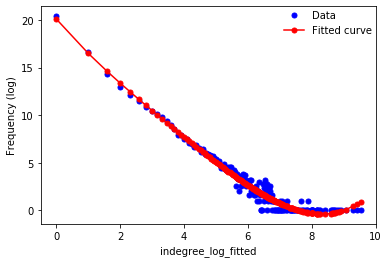

In [20]:
perc_Ys_dev = 95
perc_Xs = 5

indegree_discrete_distr = dict(collections.OrderedDict(sorted(dict(Counter(indegree_distr)).items())))
unique_values, frequencies = list(indegree_discrete_distr.keys()), \
                                    list(indegree_discrete_distr.values())
Xs_abn = [_indegree for _indegree, _claimer in zip(indegree_distr, claimers) 
          if str(_claimer) in cusIdx2Labels.keys() and cusIdx2Labels[str(_claimer)] == 1]
draw_distr_log(unique_values, frequencies, Xs_abn, 'indegree_log_fitted')

sus_cus_indegree_logSpike, sus_scores_indegree_logSpike = logSpikeFilter(indegree_distr, claimers, 
                                                                           "indegree", perc_Ys_dev, perc_Xs)

In [21]:
len(sus_cus_indegree_logSpike), len(sus_scores_indegree_logSpike)

(38, 1516956)

###### outdegree

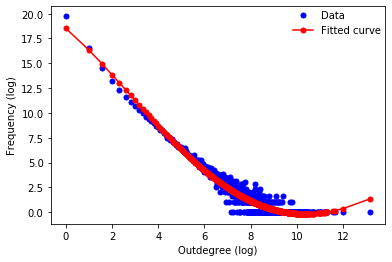

In [22]:
outdegree_discrete_distr = dict(collections.OrderedDict(sorted(dict(Counter(outdegree_distr)).items())))
unique_values, frequencies = list(outdegree_discrete_distr.keys()), \
                                    list(outdegree_discrete_distr.values())
Xs_abn = [_outdegree for _outdegree, _giver in zip(outdegree_distr, givers) 
          if str(_giver) in cusIdx2Labels.keys() and cusIdx2Labels[str(_giver)] == 1]
draw_distr_log(unique_values, frequencies, Xs_abn, 'Outdegree (log)')

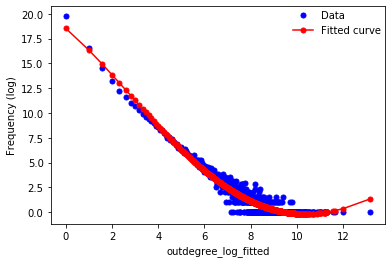

In [23]:
perc_Ys_dev = 90
perc_Xs = 5

outdegree_discrete_distr = dict(collections.OrderedDict(sorted(dict(Counter(outdegree_distr)).items())))
unique_values, frequencies = list(outdegree_discrete_distr.keys()), \
                                    list(outdegree_discrete_distr.values())
Xs_abn = [_outdegree for _outdegree, _giver in zip(outdegree_distr, givers) 
          if str(_giver) in cusIdx2Labels.keys() and cusIdx2Labels[str(_giver)] == 1]
draw_distr_log(unique_values, frequencies, Xs_abn, 'outdegree_log_fitted')

sus_cus_outdegree_logSpike, sus_scores_outdegree_logSpike = logSpikeFilter(outdegree_distr, givers, 
                                                                           "outdegree", perc_Ys_dev, perc_Xs)

In [24]:
len(sus_cus_outdegree_logSpike), len(sus_scores_outdegree_logSpike)

(169, 1030347)

###### raw count

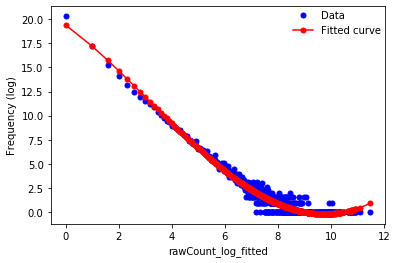

In [25]:
perc_Ys_dev = 90
perc_Xs = 5

indegree_rawCount_discrete_distr = dict(collections.OrderedDict(sorted(dict(Counter(indegree_rawCount_distr)).items())))
unique_values, frequencies = list(indegree_rawCount_discrete_distr.keys()), \
                                    list(indegree_rawCount_discrete_distr.values())

Xs_abn = [_rawCount for _rawCount, _claimer in zip(indegree_rawCount_distr, claimers) 
              if str(_claimer) in cusIdx2Labels.keys() and cusIdx2Labels[str(_claimer)] == 1]

draw_distr_log(unique_values, frequencies, Xs_abn, 'rawCount_log_fitted')

sus_cus_inRawCount_logSpike, sus_scores_inRawCount_logSpike = logSpikeFilter(indegree_rawCount_distr, claimers, 
                                                                         "rawCount", perc_Ys_dev, perc_Xs)

In [26]:
len(sus_cus_inRawCount_logSpike), len(sus_scores_inRawCount_logSpike)

(142, 1516956)

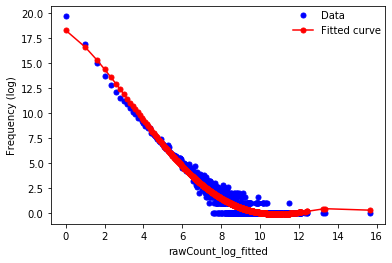

In [27]:
perc_Ys_dev = 90
perc_Xs = 5

outdegree_rawCount_discrete_distr = dict(collections.OrderedDict(sorted(dict(Counter(outdegree_rawCount_distr)).items())))
unique_values, frequencies = list(outdegree_rawCount_discrete_distr.keys()), \
                                    list(outdegree_rawCount_discrete_distr.values())

Xs_abn = [_rawCount for _rawCount, _giver in zip(outdegree_rawCount_distr, givers) 
              if str(_giver) in cusIdx2Labels.keys() and cusIdx2Labels[str(_giver)] == 1]

draw_distr_log(unique_values, frequencies, Xs_abn, 'rawCount_log_fitted')

sus_cus_outRawCount_logSpike, sus_scores_outRawCount_logSpike = logSpikeFilter(outdegree_rawCount_distr, givers, 
                                                                         "rawCount", perc_Ys_dev, perc_Xs)

In [28]:
len(sus_cus_outRawCount_logSpike), len(sus_scores_outRawCount_logSpike)

(233, 1030347)

###### denomination

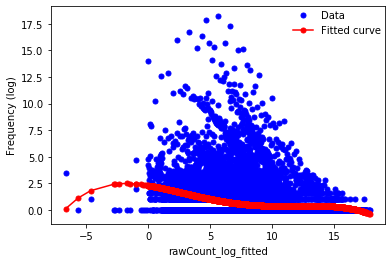

In [29]:
perc_Ys_dev = 99
perc_Xs = 95

indegree_denomi_discrete_distr = dict(collections.OrderedDict(sorted(dict(Counter(indegree_denomi_distr)).items())))
unique_values, frequencies = list(indegree_denomi_discrete_distr.keys()), \
                                    list(indegree_denomi_discrete_distr.values())

Xs_abn = [_denomi for _denomi, _claimer in zip(indegree_denomi_distr, claimers) 
              if str(_claimer) in cusIdx2Labels.keys() and cusIdx2Labels[str(_claimer)] == 1]

draw_distr_log(unique_values, frequencies, Xs_abn, 'rawCount_log_fitted')

sus_cus_inDenomination_logSpike, sus_scores_inDenomination_logSpike = logSpikeFilter(indegree_denomi_distr, claimers, 
                                                                                 "denomination", perc_Ys_dev, perc_Xs)

In [30]:
len(sus_cus_inDenomination_logSpike), len(sus_scores_inDenomination_logSpike)

(53228, 1516956)

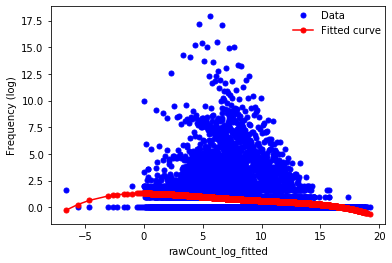

In [31]:
perc_Ys_dev = 95
perc_Xs = 90

outdegree_denomi_discrete_distr = dict(collections.OrderedDict(sorted(dict(Counter(outdegree_denomi_distr)).items())))
unique_values, frequencies = list(outdegree_denomi_discrete_distr.keys()), \
                                    list(outdegree_denomi_discrete_distr.values())

Xs_abn = [_denomi for _denomi, _giver in zip(outdegree_denomi_distr, givers) 
              if str(_giver) in cusIdx2Labels.keys() and cusIdx2Labels[str(_giver)] == 1]

draw_distr_log(unique_values, frequencies, Xs_abn, 'rawCount_log_fitted')

sus_cus_outDenomination_logSpike, sus_scores_outDenomination_logSpike = logSpikeFilter(outdegree_denomi_distr, givers, 
                                                                                 "denomination", perc_Ys_dev, perc_Xs)

In [32]:
len(sus_cus_outDenomination_logSpike), len(sus_scores_outDenomination_logSpike)

(63632, 1030347)

In [33]:
sus_cus_logSpike = set(sus_cus_indegree_logSpike).union(set(sus_cus_outdegree_logSpike)).union(
                  set(sus_cus_inRawCount_logSpike)).union(set(sus_cus_outRawCount_logSpike)).union(
                  set(sus_cus_inDenomination_logSpike)).union(set(sus_cus_outDenomination_logSpike))

In [34]:
len(sus_cus_logSpike)

116993

In [35]:
sus_scores_in_logSpike = {}
for _usr in sus_scores_indegree_logSpike.keys():
    sus_scores_in_logSpike[_usr] = np.max([sus_scores_indegree_logSpike[_usr],
                                        sus_scores_inRawCount_logSpike[_usr]
                                        ,sus_scores_inDenomination_logSpike[_usr]
                                          ])
sus_scores_out_logSpike = {}
for _usr in sus_scores_outdegree_logSpike.keys():
    sus_scores_out_logSpike[_usr] = np.max([sus_scores_outdegree_logSpike[_usr], 
                                            sus_scores_outRawCount_logSpike[_usr]
                                            ,sus_scores_outDenomination_logSpike[_usr]
                                           ])
sus_scores_logSpike = {}
sus_scores_logSpike.update(sus_scores_in_logSpike)
sus_scores_logSpike.update(sus_scores_out_logSpike)

In [36]:
len(sus_scores_logSpike)

2490958

In [37]:
sus_scores_logSpike_norm = dict(zip(list(sus_scores_logSpike.keys()), 
                                     list(sus_scores_logSpike.values())/np.linalg.norm(
                                        list(sus_scores_logSpike.values())).astype(float)))

In [38]:
sampling_customers_logSpike = set(np.array(list(cusIdx2Labels.keys())).astype(int).tolist()).intersection(set(sus_cus_logSpike))

In [39]:
len(sampling_customers_logSpike)

246

In [40]:
_predited_labels = [cusIdx2Labels[str(_cIdx)] for _cIdx in sampling_customers_logSpike]
print("{:<30} {:<30} {:<30}".format('# of suspicious','# of real','Precision'))
print(" ")
print("{:<30} {:<30} {:<30}".format(
    len(_predited_labels), np.sum(_predited_labels),round(np.sum(_predited_labels)/float(len(_predited_labels)), 4)))

# of suspicious                # of real                      Precision                     
 
246                            122                            0.4959                        


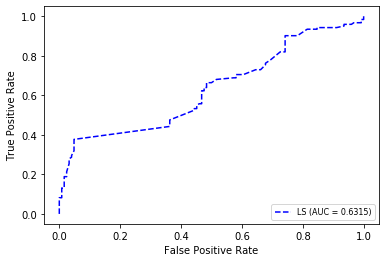

In [41]:
y = [cusIdx2Labels[str(_cIdx)] for _cIdx in sampling_customers_logSpike]
_sus_score = [sus_scores_logSpike_norm[_cIdx] for _cIdx in sampling_customers_logSpike]
_ = AUC([_sus_score], [y], score_type, colorLineSet, linestyles)

In [42]:
y_true = list(cusIdx2Labels.values())
y_predict = [1 if int(_cIdx) in sus_cus_logSpike else 0 for _cIdx in cusIdx2Labels.keys()]
print(classification_report(y_true, y_predict, target_names=['0', '1'], digits=4))

              precision    recall  f1-score   support

           0     0.4522    0.6320    0.5272       337
           1     0.4959    0.3211    0.3898       380

    accuracy                         0.4672       717
   macro avg     0.4741    0.4766    0.4585       717
weighted avg     0.4754    0.4672    0.4544       717



In [43]:
accuracy_score(y_true, y_predict)

0.46722454672245467

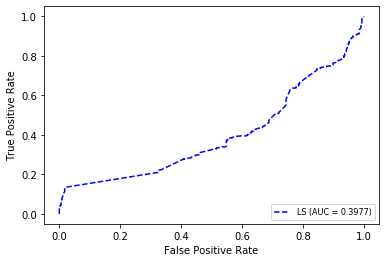

In [44]:
_sus_score = [sus_scores_logSpike_norm[int(_cIdx)] for _cIdx in cusIdx2Labels.keys()]
_ = AUC([_sus_score], [y_true], score_type, colorLineSet, linestyles)

##### 3.2 oddRatio

In [45]:
perc_Ys_dev = 95
perc_Xs = 95

ux_indegree, x_indegree, y_indegree, y_fitted_indegree \
= eng.eval('powerwall(%s)'%indegree_distr, nargout=4)

ux_indegree, x_indegree, y_indegree, y_fitted_indegree \
= np.asarray(ux_indegree).flatten(), np.asarray(x_indegree).flatten(), \
np.asarray(y_indegree).flatten(), np.asarray(y_fitted_indegree).flatten()

sus_cus_indegree_oddRatio, sus_scores_indegree_oddRatio = OddsRatioFilter(ux_indegree, y_indegree, y_fitted_indegree,
                                          indegree_distr, claimers, "indegree", perc_Ys_dev, perc_Xs)

In [46]:
len(sus_cus_indegree_oddRatio), len(sus_scores_indegree_oddRatio)

(29045, 1516956)

In [47]:
perc_Ys_dev = 95
perc_Xs = 95

ux_outdegree, x_outdegree, y_outdegree, y_fitted_outdegree \
= eng.eval('powerwall(%s)'%outdegree_distr, nargout=4)

ux_outdegree, x_outdegree, y_outdegree, y_fitted_outdegree \
= np.asarray(ux_outdegree).flatten(), np.asarray(x_outdegree).flatten(), \
np.asarray(y_outdegree).flatten(), np.asarray(y_fitted_outdegree).flatten()

sus_cus_outdegree_oddRatio, sus_scores_outdegree_oddRatio= OddsRatioFilter(ux_outdegree, y_outdegree, 
                                          y_fitted_outdegree, outdegree_distr, givers, "outdegree", 
                                          perc_Ys_dev, perc_Xs)

In [48]:
len(sus_cus_outdegree_oddRatio)

24176

In [49]:

perc_Ys_dev = 95
perc_Xs = 80

ux_inRawCount, x_inRawCount, y_inRawCount, y_fitted_inRawCount \
= eng.eval('powerwall(%s)'%indegree_rawCount_distr, nargout=4)

ux_inRawCount, x_inRawCount, y_inRawCount, y_fitted_inRawCount \
= np.asarray(ux_inRawCount).flatten(), np.asarray(x_inRawCount).flatten(), \
np.asarray(y_inRawCount).flatten(), np.asarray(y_fitted_inRawCount).flatten()

sus_cus_inRawCount_oddRatio, sus_scores_inRawCount_oddRatio = OddsRatioFilter(ux_inRawCount, y_inRawCount, y_fitted_inRawCount,
                                          indegree_rawCount_distr, claimers, "inRawCount", perc_Ys_dev, perc_Xs)

In [50]:
len(sus_cus_inRawCount_oddRatio), len(sus_scores_inRawCount_oddRatio)

(28165, 1516956)

In [51]:
perc_Ys_dev = 95
perc_Xs = 80

ux_outRawCount, x_outRawCount, y_outRawCount, y_fitted_outRawCount \
= eng.eval('powerwall(%s)'%outdegree_rawCount_distr, nargout=4)

ux_outRawCount, x_outRawCount, y_outRawCount, y_fitted_outRawCount \
= np.asarray(ux_outRawCount).flatten(), np.asarray(x_outRawCount).flatten(), \
np.asarray(y_outRawCount).flatten(), np.asarray(y_fitted_outRawCount).flatten()

sus_cus_outRawCount_oddRatio, sus_scores_outRawCount_oddRatio = OddsRatioFilter(ux_outRawCount, y_outRawCount, y_fitted_outRawCount,
                                          outdegree_rawCount_distr, givers, "outRawCount", perc_Ys_dev, perc_Xs)

In [52]:
len(sus_cus_outRawCount_oddRatio), len(sus_scores_outRawCount_oddRatio)

(35032, 1030347)

In [53]:
perc_Ys_dev = 95
perc_Xs = 5

ux_inDenomination, x_inDenomination, y_inDenomination, y_fitted_inDenomination \
= eng.eval('powerwall(%s)'%indegree_denomi_distr, nargout=4)

ux_inDenomination, x_inDenomination, y_inDenomination, y_fitted_inDenomination \
= np.asarray(ux_inDenomination).flatten(), np.asarray(x_inDenomination).flatten(), \
np.asarray(y_inDenomination).flatten(), np.asarray(y_fitted_inDenomination).flatten()

sus_cus_inDenomination_oddRatio, sus_scores_inDenomination_oddRatio = OddsRatioFilter(ux_inDenomination, y_inDenomination, y_fitted_inDenomination,
                                          indegree_denomi_distr, claimers, "inDenomination", perc_Ys_dev, perc_Xs)

In [54]:
len(sus_cus_inDenomination_oddRatio), len(sus_scores_inDenomination_oddRatio)

(3050, 1516956)

In [55]:
perc_Ys_dev = 95
perc_Xs = 5

ux_outDenomination, x_outDenomination, y_outDenomination, y_fitted_outDenomination \
= eng.eval('powerwall(%s)'%outdegree_denomi_distr, nargout=4)

ux_outDenomination, x_outDenomination, y_outDenomination, y_fitted_outDenomination \
= np.asarray(ux_outDenomination).flatten(), np.asarray(x_outDenomination).flatten(), \
np.asarray(y_outDenomination).flatten(), np.asarray(y_fitted_outDenomination).flatten()

sus_cus_outDenomination_oddRatio, sus_scores_outDenomination_oddRatio = OddsRatioFilter(ux_outDenomination, 
                                        y_outDenomination, y_fitted_outDenomination, outdegree_denomi_distr, 
                                        givers, "outDenomination", perc_Ys_dev, perc_Xs)

In [56]:
len(sus_cus_outDenomination_oddRatio), len(sus_scores_outDenomination_oddRatio)

(461, 1030347)

In [57]:
sus_cus_oddRatio = set(sus_cus_indegree_oddRatio).union(set(sus_cus_outdegree_oddRatio)).union(
                  set(sus_cus_inRawCount_oddRatio)).union(set(sus_cus_outRawCount_oddRatio)).union(
                  set(sus_cus_inDenomination_oddRatio)).union(set(sus_cus_outDenomination_oddRatio))

In [58]:
len(sus_cus_oddRatio)

86243

In [59]:
sus_scores_in_oddRatio = {}
for _usr in sus_scores_indegree_oddRatio.keys():
    sus_scores_in_oddRatio[_usr] = np.max([sus_scores_indegree_oddRatio[_usr],
                                        sus_scores_inRawCount_oddRatio[_usr]
                                        ,sus_scores_inDenomination_oddRatio[_usr]
                                          ])
sus_scores_out_oddRatio = {}
for _usr in sus_scores_outdegree_oddRatio.keys():
    sus_scores_out_oddRatio[_usr] = np.max([sus_scores_outdegree_oddRatio[_usr], 
                                            sus_scores_outRawCount_oddRatio[_usr]
                                            ,sus_scores_outDenomination_oddRatio[_usr]
                                           ])
sus_scores_oddRatio = {}
sus_scores_oddRatio.update(sus_scores_in_oddRatio)
sus_scores_oddRatio.update(sus_scores_out_oddRatio)

In [60]:
sus_scores_oddRatio_norm = dict(zip(list(sus_scores_oddRatio.keys()), 
                                     list(sus_scores_oddRatio.values())/np.linalg.norm(
                                        list(sus_scores_oddRatio.values())).astype(float)))

In [61]:
sampling_customers_oddRatio = set(np.array(list(cusIdx2Labels.keys())).astype(int).tolist()).intersection(set(sus_cus_oddRatio))

In [62]:
_predited_labels = [cusIdx2Labels[str(_cIdx)] for _cIdx in sampling_customers_oddRatio]
print("{:<30} {:<30} {:<30}".format('# of suspicious','# of real','Precision'))
print(" ")
print("{:<30} {:<30} {:<30}".format(
    len(_predited_labels), np.sum(_predited_labels),round(np.sum(_predited_labels)/float(len(_predited_labels)), 4)))

# of suspicious                # of real                      Precision                     
 
435                            295                            0.6782                        


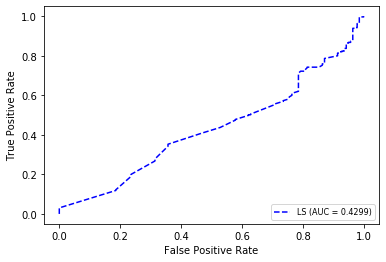

In [63]:
y = [cusIdx2Labels[str(_cIdx)] for _cIdx in sampling_customers_oddRatio]
_sus_score = [sus_scores_oddRatio_norm[_cIdx] for _cIdx in sampling_customers_oddRatio]
_ = AUC([_sus_score], [y], score_type, colorLineSet, linestyles)

In [64]:
y_true = list(cusIdx2Labels.values())
y_predict = [1 if int(_cIdx) in sus_cus_oddRatio else 0 for _cIdx in cusIdx2Labels.keys()]
print(classification_report(y_true, y_predict, target_names=['0', '1'], digits=4))

              precision    recall  f1-score   support

           0     0.6986    0.5846    0.6365       337
           1     0.6782    0.7763    0.7239       380

    accuracy                         0.6862       717
   macro avg     0.6884    0.6804    0.6802       717
weighted avg     0.6878    0.6862    0.6828       717



In [65]:
accuracy_score(y_true, y_predict)

0.6861924686192469

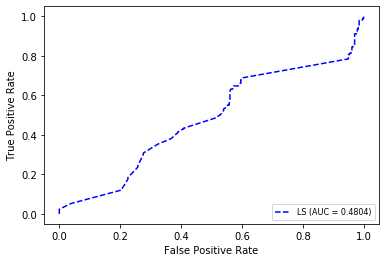

In [66]:
_sus_score = [sus_scores_oddRatio_norm[int(_cIdx)] for _cIdx in cusIdx2Labels.keys()]
_ = AUC([_sus_score], [y_true], score_type, colorLineSet, linestyles)

##### 3.3 spetralRay

##### logSpike + spectralRay

In [67]:

len(sus_cus_logSpike)

116993

In [68]:
with open('%s/LogSpikeData/giver_claimer_wtgraph_binary_log_spike.txt'%repos_root, "w") as f:
    for _claimer in sus_cus_logSpike:
        try:
            for _giver in claimer_2_giver[_claimer]:
                f.write(str(_giver) + " " + str(_claimer) + " " + str(G_binary[_giver][_claimer]['binary']) + "\n")
        except KeyError:
            continue

In [69]:
adj_binary_logSpike = svd_new.load_matrix('%s/LogSpikeData/giver_claimer_wtgraph_binary_log_spike.txt'%repos_root, 
                                          shape=(num_cid, num_cid))

In [70]:
sus_cus_logSpike_spectralRay, sus_score_logSpike_spectralRay = SpectralRay(3, adj_binary_logSpike, 1)

In [71]:
len(sus_cus_logSpike_spectralRay), len(sus_score_logSpike_spectralRay)

(1150, 1150)

In [72]:
for _cIdx, _sus_score in sus_scores_logSpike.items():
    if _cIdx in sus_score_logSpike_spectralRay.keys():
        sus_score_logSpike_spectralRay[_cIdx] = np.exp(sus_score_logSpike_spectralRay[_cIdx]) * _sus_score
    else:
        sus_score_logSpike_spectralRay[_cIdx] = _sus_score

In [73]:
sus_score_logSpike_spectralRay_norm = dict(zip(list(sus_score_logSpike_spectralRay.keys()), 
                                     list(sus_score_logSpike_spectralRay.values())/np.linalg.norm(
                                        list(sus_score_logSpike_spectralRay.values())).astype(float)))

In [74]:
sampling_customers_logSpike_spectralRay = set(np.array(list(cusIdx2Labels.keys())).astype(int).tolist()).intersection(set(sus_cus_logSpike_spectralRay))

In [75]:
len(sampling_customers_logSpike_spectralRay)

92

In [76]:
_predited_labels = [cusIdx2Labels[str(_cIdx)] for _cIdx in sampling_customers_logSpike_spectralRay]
print("{:<30} {:<30} {:<30}".format('# of suspicious','# of real','Precision'))
print(" ")
print("{:<30} {:<30} {:<30}".format(
    len(_predited_labels), np.sum(_predited_labels),round(np.sum(_predited_labels)/float(len(_predited_labels)), 4)))

# of suspicious                # of real                      Precision                     
 
92                             80                             0.8696                        


In [77]:
y_true = list(cusIdx2Labels.values())
y_predict = [1 if int(_cIdx) in sus_cus_logSpike_spectralRay else 0 for _cIdx in cusIdx2Labels.keys()]
print(classification_report(y_true, y_predict, target_names=['0', '1'], digits=4))

              precision    recall  f1-score   support

           0     0.5200    0.9644    0.6757       337
           1     0.8696    0.2105    0.3390       380

    accuracy                         0.5649       717
   macro avg     0.6948    0.5875    0.5073       717
weighted avg     0.7053    0.5649    0.4972       717



In [78]:
accuracy_score(y_true, y_predict)

0.5648535564853556

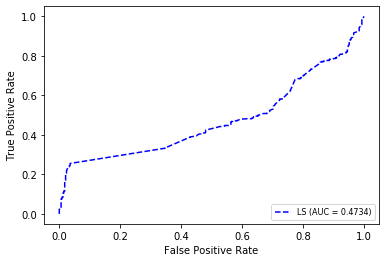

In [79]:
_sus_score = [sus_score_logSpike_spectralRay_norm[int(_cIdx)] for _cIdx in cusIdx2Labels.keys()]
_ = AUC([_sus_score], [y_true], score_type, colorLineSet, linestyles)

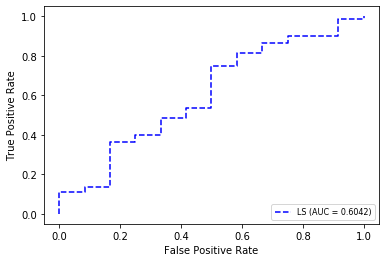

In [80]:
y = [cusIdx2Labels[str(_cIdx)] for _cIdx in sampling_customers_logSpike_spectralRay]
_sus_score = [sus_score_logSpike_spectralRay_norm[_cIdx] for _cIdx in sampling_customers_logSpike_spectralRay]
_ = AUC([_sus_score], [y], score_type, colorLineSet, linestyles)

##### oddRatio + spectralRay

In [81]:
len(sus_cus_oddRatio)

86243

In [82]:
with open('%s/OddsRatioData/giver_claimer_wtgraph_binary_odd_ratio.txt'%repos_root, "w") as f:
    for _claimer in sus_cus_oddRatio:
        try:
            for _giver in claimer_2_giver[_claimer]:
                f.write(str(_giver) + " " + str(_claimer) + " " + str(G_binary[_giver][_claimer]['binary']) + "\n")
        except KeyError:
            continue

In [83]:
adj_binary_oddRatio = svd_new.load_matrix('%s/OddsRatioData/giver_claimer_wtgraph_binary_odd_ratio.txt'%repos_root, 
                                          shape=(num_cid, num_cid))
# adj_raw_count_oddRatio = svd_new.load_matrix('%s/OddsRatioData/giver_claimer_wtgraph_raw_count_odd_ratio.txt'%repos_root, 
#                                           shape=(num_cid, num_cid))

In [84]:
sus_cus_oddRatio_spectralRay, sus_score_oddRatio_spectralRay = SpectralRay(3, adj_binary_oddRatio, 1)
# sus_cus_oddRatio_spectralRay_rawCount, sus_score_oddRatio_spectralRay_rawCount = SpectralRay(5, adj_raw_count_oddRatio, 1)

In [85]:
len(sus_cus_oddRatio_spectralRay), len(sus_score_oddRatio_spectralRay)

(998, 998)

In [86]:
len(sus_score_oddRatio_spectralRay)

998

In [87]:
for _cIdx, _sus_score in sus_scores_oddRatio.items():
    if _cIdx in sus_score_oddRatio_spectralRay .keys():
        sus_score_oddRatio_spectralRay[_cIdx] = np.exp(sus_score_oddRatio_spectralRay[_cIdx]) * _sus_score
    else:
        sus_score_oddRatio_spectralRay[_cIdx] = _sus_score

In [88]:
sus_score_oddRatio_spectralRay_norm = dict(zip(list(sus_score_oddRatio_spectralRay.keys()), 
                                     list(sus_score_oddRatio_spectralRay.values())/np.linalg.norm(
                                        list(sus_score_oddRatio_spectralRay.values())).astype(float)))

In [89]:
sampling_customers_oddRatio_spectralRay = set(np.array(list(cusIdx2Labels.keys())).astype(int).tolist()).intersection(set(sus_cus_oddRatio_spectralRay))

In [90]:
len(sampling_customers_oddRatio_spectralRay)

120

In [91]:
_predited_labels = [cusIdx2Labels[str(_cIdx)] for _cIdx in sampling_customers_oddRatio_spectralRay]
print("{:<30} {:<30} {:<30}".format('# of suspicious','# of real','Precision'))
print(" ")
print("{:<30} {:<30} {:<30}".format(
    len(_predited_labels), np.sum(_predited_labels),round(np.sum(_predited_labels)/float(len(_predited_labels)), 4)))

# of suspicious                # of real                      Precision                     
 
120                            106                            0.8833                        


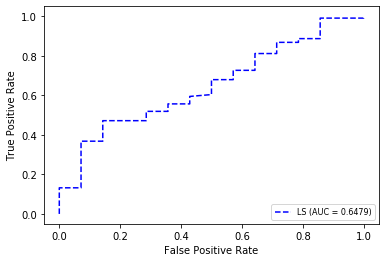

In [92]:
y = [cusIdx2Labels[str(_cIdx)] for _cIdx in sampling_customers_oddRatio_spectralRay]
_sus_score = [sus_score_oddRatio_spectralRay_norm[_cIdx] for _cIdx in sampling_customers_oddRatio_spectralRay]
_ = AUC([_sus_score], [y], score_type, colorLineSet, linestyles)

In [93]:
y_true = list(cusIdx2Labels.values())
y_predict = [1 if int(_cIdx) in sus_cus_oddRatio_spectralRay else 0 for _cIdx in cusIdx2Labels.keys()]
print(classification_report(y_true, y_predict, target_names=['0', '1'], digits=4))

              precision    recall  f1-score   support

           0     0.5410    0.9585    0.6916       337
           1     0.8833    0.2789    0.4240       380

    accuracy                         0.5983       717
   macro avg     0.7122    0.6187    0.5578       717
weighted avg     0.7224    0.5983    0.5498       717



In [94]:
accuracy_score(y_true, y_predict)

0.5983263598326359

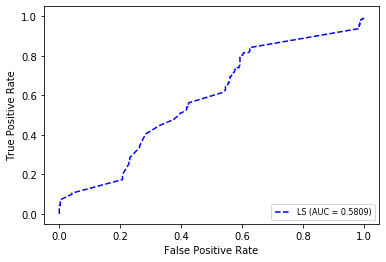

In [95]:
_sus_score = [sus_score_oddRatio_spectralRay_norm[int(_cIdx)] for _cIdx in cusIdx2Labels.keys()]
_ = AUC([_sus_score], [y_true], score_type, colorLineSet, linestyles)

##### (logSpike + oddRatio) + spectralRay

In [96]:
sus_cus_spetralRay = set(sus_cus_logSpike).union(set(sus_cus_oddRatio))

In [97]:
len(sus_cus_spetralRay)

180821

In [98]:
with open('%s/OperaData/giver_claimer_wtgraph_binary_log_spike_odd_ratio.txt'%repos_root, "w") as f:
    for _claimer in sus_cus_spetralRay:
        try:
            for _giver in claimer_2_giver[_claimer]:
                f.write(str(_giver) + " " + str(_claimer) + " " + str(G_binary[_giver][_claimer]['binary']) + "\n")
        except KeyError:
            continue

In [99]:
adj_binary_logSpike_oddRatio = svd_new.load_matrix('%s/OperaData/giver_claimer_wtgraph_binary_log_spike_odd_ratio.txt'%repos_root, 
                                          shape=(num_cid, num_cid))

In [100]:
sus_cus_logSpike_oddRatio_spectralRay, sus_score_logSpike_oddRatio_spectralRay = SpectralRay(3, adj_binary_logSpike_oddRatio, 1)

In [101]:
len(sus_cus_logSpike_oddRatio_spectralRay), len(sus_score_logSpike_oddRatio_spectralRay)

(1334, 1334)

In [102]:
sus_scores_logSpike_oddRatio = {}
for _cIdx, _score in sus_scores_oddRatio.items():
    sus_scores_logSpike_oddRatio[_cIdx] = np.mean([_score, sus_scores_logSpike[_cIdx]])

In [103]:
for _cIdx, _sus_score in sus_scores_logSpike_oddRatio.items():
    if _cIdx in  sus_score_logSpike_oddRatio_spectralRay.keys():
         sus_score_logSpike_oddRatio_spectralRay[_cIdx] =  np.exp(sus_score_logSpike_oddRatio_spectralRay[_cIdx]) * _sus_score
    else:
         sus_score_logSpike_oddRatio_spectralRay[_cIdx] = _sus_score

In [104]:
sus_score_logSpike_oddRatio_spectralRay_norm = dict(zip(list(sus_score_logSpike_oddRatio_spectralRay.keys()), 
                                     list(sus_score_logSpike_oddRatio_spectralRay.values())/np.linalg.norm(
                                        list(sus_score_logSpike_oddRatio_spectralRay.values())).astype(float)))

In [105]:
sampling_customers_logSpike_oddRatio_spectralRay = set(np.array(list(cusIdx2Labels.keys())).astype(int).tolist()).intersection(set(sus_cus_logSpike_oddRatio_spectralRay))

In [106]:
len(sampling_customers_logSpike_oddRatio_spectralRay)

119

In [107]:
_predited_labels = [cusIdx2Labels[str(_cIdx)] for _cIdx in sampling_customers_logSpike_oddRatio_spectralRay]
print("{:<30} {:<30} {:<30}".format('# of suspicious','# of real','Precision'))
print(" ")
print("{:<30} {:<30} {:<30}".format(
    len(_predited_labels), np.sum(_predited_labels),round(np.sum(_predited_labels)/float(len(_predited_labels)), 4)))

# of suspicious                # of real                      Precision                     
 
119                            106                            0.8908                        


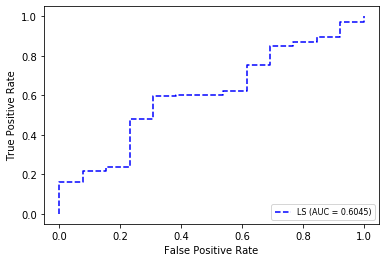

In [108]:
y = [cusIdx2Labels[str(_cIdx)] for _cIdx in sampling_customers_logSpike_oddRatio_spectralRay]
_sus_score = [sus_score_logSpike_oddRatio_spectralRay_norm[_cIdx] for _cIdx in sampling_customers_logSpike_oddRatio_spectralRay]
_ = AUC([_sus_score], [y], score_type, colorLineSet, linestyles)

In [109]:
y_true = list(cusIdx2Labels.values())
y_predict = [1 if int(_cIdx) in sus_cus_logSpike_oddRatio_spectralRay else 0 for _cIdx in cusIdx2Labels.keys()]
print(classification_report(y_true, y_predict, target_names=['0', '1'], digits=4))

              precision    recall  f1-score   support

           0     0.5418    0.9614    0.6930       337
           1     0.8908    0.2789    0.4248       380

    accuracy                         0.5997       717
   macro avg     0.7163    0.6202    0.5589       717
weighted avg     0.7267    0.5997    0.5509       717



In [110]:
accuracy_score(y_true, y_predict)

0.599721059972106

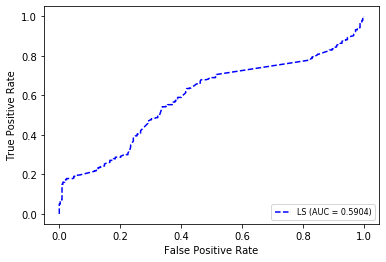

In [111]:
_sus_score = [sus_score_logSpike_oddRatio_spectralRay_norm[int(_cIdx)] for _cIdx in cusIdx2Labels.keys()]
_ = AUC([_sus_score], [y_true], score_type, colorLineSet, linestyles)

In [112]:
customer_union = set(sampling_customers_logSpike).union(sampling_customers_oddRatio
                ).union(sampling_customers_logSpike_spectralRay).union(sampling_customers_oddRatio_spectralRay).union(
                sampling_customers_logSpike_oddRatio_spectralRay)
customer_union = list(customer_union)

In [113]:
type(customer_union)

list

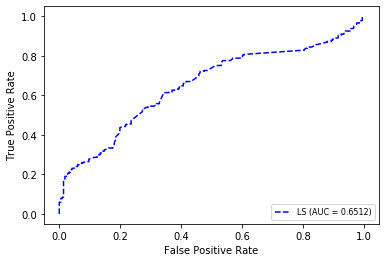

In [114]:
y_true_union = [cusIdx2Labels[str(_cIdx)] for _cIdx in customer_union]
_sus_score_logSpike_oddRatio_spectralRay = [sus_score_logSpike_oddRatio_spectralRay_norm[int(_cIdx)] for _cIdx in customer_union]
_ = AUC([_sus_score_logSpike_oddRatio_spectralRay], [y_true_union], score_type, colorLineSet, linestyles)

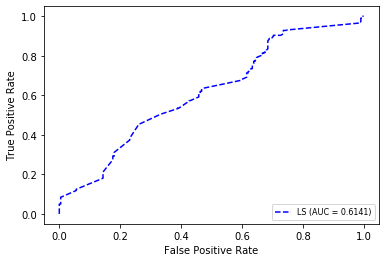

In [115]:
y_true_union = [cusIdx2Labels[str(_cIdx)] for _cIdx in customer_union]
_sus_score_oddRatio_spectralRay = [sus_score_oddRatio_spectralRay_norm[int(_cIdx)] for _cIdx in customer_union]
_ = AUC([_sus_score_oddRatio_spectralRay], [y_true_union], score_type, colorLineSet, linestyles)

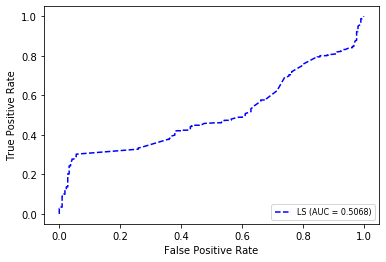

In [116]:
y_true_union = [cusIdx2Labels[str(_cIdx)] for _cIdx in customer_union]
_sus_score_logSpike_spectralRay = [sus_score_logSpike_spectralRay_norm[int(_cIdx)] for _cIdx in customer_union]
_ = AUC([_sus_score_logSpike_spectralRay], [y_true_union], score_type, colorLineSet, linestyles)

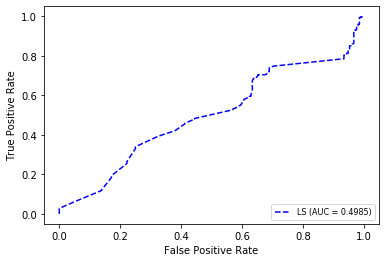

In [117]:
y_true_union = [cusIdx2Labels[str(_cIdx)] for _cIdx in customer_union]
_sus_score_oddRatio = [sus_scores_oddRatio_norm[int(_cIdx)] for _cIdx in customer_union]
_ = AUC([_sus_score_oddRatio], [y_true_union], score_type, colorLineSet, linestyles)

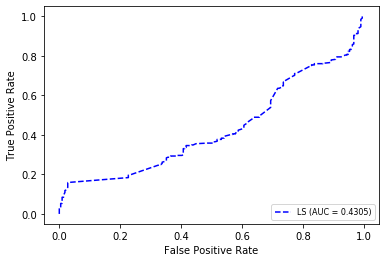

In [118]:
y_true_union = [cusIdx2Labels[str(_cIdx)] for _cIdx in customer_union]
_sus_score_logSpike = [sus_scores_logSpike_norm[int(_cIdx)] for _cIdx in customer_union]
_ = AUC([_sus_score_logSpike], [y_true_union], score_type, colorLineSet, linestyles)

##### Baselines

In [119]:
data = []
data_union = []
# y_true_union = []
y_true_index = []
cIdx = []
cus_flag = dict([(_cIdx, 0)for _cIdx in customer_union])
for _indegree, _indegree_rawcount, _indegree_denomi, _claimer in zip(indegree_distr, 
                                                                   indegree_rawCount_distr,
                                                                   indegree_denomi_distr, 
                                                                   claimers):
    if _claimer in customer_union:
        data_union.append([_indegree, _indegree_rawcount, _indegree_denomi])
#         y_true_union.append(cusIdx2Labels[str(_claimer)])
        y_true_index.append(customer_union.index(_claimer))
        cus_flag[_claimer] = 1
    else: 
        data.append([_indegree, _indegree_rawcount, _indegree_denomi])

for _outdegree, _outdegree_rawcount, _outdegree_denomi, _giver in zip(outdegree_distr, 
                                                                   outdegree_rawCount_distr,
                                                                   outdegree_denomi_distr, 
                                                                   givers):
    if _giver in customer_union and not cus_flag[_giver]:
        data_union.append([_outdegree, _outdegree_rawcount, _outdegree_denomi])
#         y_true_union.append(cusIdx2Labels[str(_giver)])
        y_true_index.append(customer_union.index(_giver))
    else:
        data.append([_outdegree, _outdegree_rawcount, _outdegree_denomi])

In [120]:
data_union = [x for _,x in sorted(zip(y_true_index, data_union))]

In [121]:
len(data), len(data_union), len(y_true_union)

(2546766, 537, 537)

In [122]:
data_train = random.sample(data, k=10000)

In [123]:
np.array(data_train).shape, np.array(data_union).shape

((10000, 3), (537, 3))

In [124]:
data_fit = np.array(data_train + data_union)

In [125]:
data_fit.shape

(10537, 3)

              precision    recall  f1-score   support

           0     0.3517    0.5602    0.4321       216
           1     0.5078    0.3053    0.3813       321

    accuracy                         0.4078       537
   macro avg     0.4298    0.4327    0.4067       537
weighted avg     0.4450    0.4078    0.4018       537



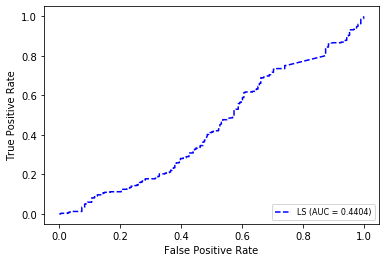

In [126]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1, novelty=False)
y_pred_union = [1 if e == -1 else 0 for e in clf.fit_predict(data_fit)][-len(data_union):]
print(classification_report(y_true_union, y_pred_union, target_names=['0', '1'], digits=4))
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1, novelty=True)
clf.fit(data_fit)
lof_oppo_score = 1 - clf.decision_function(data_union)
_ = AUC([lof_oppo_score], [y_true_union], score_type, colorLineSet, linestyles)

              precision    recall  f1-score   support

           0     0.6975    0.3843    0.4955       216
           1     0.6818    0.8879    0.7713       321

    accuracy                         0.6853       537
   macro avg     0.6896    0.6361    0.6334       537
weighted avg     0.6881    0.6853    0.6604       537



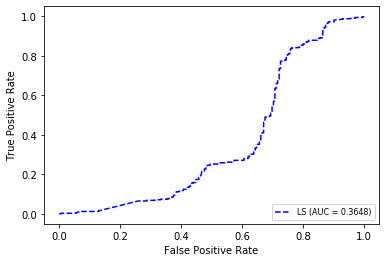

In [127]:
clf = FeatureBagging()
clf.fit(data_train)
y_pred_union = clf.predict(data_union)
print(classification_report(y_true_union, y_pred_union, target_names=['0', '1'], digits=4))

feaBag_scores = clf.decision_function(data_union) * -1
_ = AUC([feaBag_scores], [y_true_union], score_type, colorLineSet, linestyles)

/Users/panpanzheng/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       216
           1     0.5970    0.9969    0.7468       321

    accuracy                         0.5959       537
   macro avg     0.2985    0.4984    0.3734       537
weighted avg     0.3569    0.5959    0.4464       537



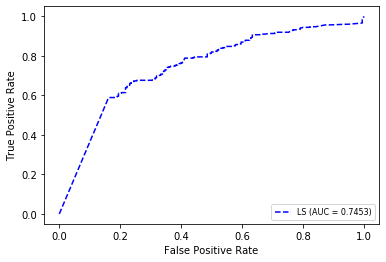

In [128]:
clf = OneClassSVM()
clf.fit(data_train)
y_pred_union = [1 if e == -1 else 0 for e in clf.predict(data_union)]
print(classification_report(y_true_union, y_pred_union, target_names=['0', '1'], digits=4))

oneClassSVM_oppo_scores = clf.score_samples(data_union)
_ = AUC([1-oneClassSVM_oppo_scores], [y_true_union], score_type, colorLineSet, linestyles)

In [129]:
X = [1,2,3,4,5]

In [130]:
X.index(5)

4

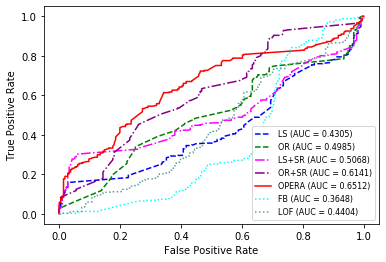

In [131]:
Data = [_sus_score_logSpike, 
        _sus_score_oddRatio, 
        _sus_score_logSpike_spectralRay, 
        _sus_score_oddRatio_spectralRay, 
        _sus_score_logSpike_oddRatio_spectralRay, 
        feaBag_scores, 
        lof_oppo_score]
Y = [y_true_union, y_true_union, y_true_union, y_true_union, y_true_union, y_true_union, y_true_union]
_ = AUC(Data, Y, score_type, colorLineSet, linestyles)

### Case Study

In [137]:
import re

###### 4.4.1 Can OPERA reveal different types of GC misuse behaviors?

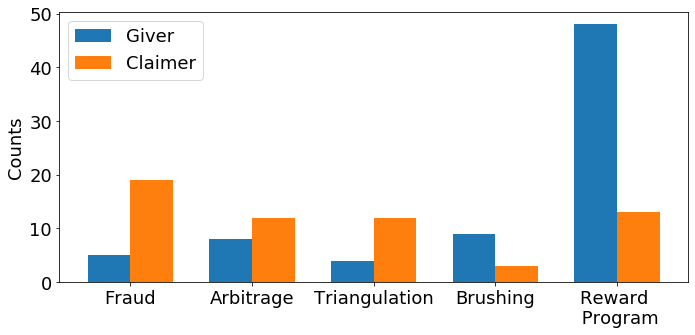

In [132]:
plt.rcParams.update({'font.size': 18})

labels = ['Fraud', 'Arbitrage', 'Triangulation', 'Brushing', 'Reward \n Program']
men_means = [5, 8, 4, 9, 48]
women_means = [19, 12, 12, 3, 13]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, men_means, width, label='Giver')
rects2 = ax.bar(x + width/2, women_means, width, label='Claimer')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
# ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height-.5),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


# autolabel(rects1)
# autolabel(rects2)

fig.tight_layout()
plt.savefig('./customer_misbehavior_histogram.png', dpi=500)
plt.show()

###### 4.4.2 Do we really need an ensemble of multiple base detectors?

In [133]:
def draw_logSpike(x, y, x_abn, labeled_cusIdices, legend_string, metric_name):

    fig = plt.figure(figsize = (8,5))
    fig.patch.set_facecolor('w')
    x_log = np.log2(x)
    y_log = np.log2(y)
    f = np.polyfit(x_log,y_log,4)
    y_log_hat = [f[0]*_x*_x*_x*_x + f[1]*_x *_x*_x + f[2]*_x*_x + f[3]*_x + f[4] for _x in x_log]
    
    markers_on = np.zeros(len(x_log))
    for j in labeled_cusIdices:
        markers_on[j] = 1
    
    dev_fit = np.abs(y_log - y_log_hat)
    detect_thrld = np.median(dev_fit[markers_on == 1])
    
    markers_on_3_category = np.zeros(len(x_log))
    for j in labeled_cusIdices:
        markers_on_3_category[j] = 1
        if dev_fit[j] >= detect_thrld:
            markers_on_3_category[j] = 2
    
    
    p1, = plt.plot(x_log, y_log, "-ob", markersize=1)
    p3, = plt.plot(x_log[markers_on_3_category == 1], y_log[markers_on_3_category == 1], "s", markersize=8, color="green")
    p4, = plt.plot(x_log[markers_on_3_category == 2], y_log[markers_on_3_category == 2], "s", markersize=8, color="purple")
    p2, = plt.plot(x_log, y_log_hat,"-or", markersize=1)
    
    plt.xlabel(r'$X_{deg}$ (log)')
    plt.ylabel("Frequency (log)")
    leg = plt.legend([p1, p2, p3, p4], ['Original', 'Fitted', '%s (undetected)'%legend_string, '%s (detected)'%legend_string], loc=0)
    leg.draw_frame(False)
    plt.savefig('./caseStudy/logSpike/%s_%s.png'%(metric_name, legend_string), dpi=1000)
    plt.show()
    plt.close()

In [134]:
def draw_oddRatio(x, y, y_log_hat, x_abn, labeled_cusIdices, legend_string, metric_name):

    fig = plt.figure(figsize = (8,5))
    fig.patch.set_facecolor('w')
    x_log = x
    y_log = y
    
    
    markers_on = np.zeros(len(x_log))
    for j in labeled_cusIdices:
        markers_on[j] = 1
        
    dev_fit = np.abs(y_log - y_log_hat)
    detect_thrld = np.median(dev_fit[markers_on == 1])
    
    markers_on_3_category = np.zeros(len(x_log))
    for j in labeled_cusIdices:
        markers_on_3_category[j] = 1
        if dev_fit[j] >= detect_thrld:
            markers_on_3_category[j] = 2
    
    p1, = plt.plot(x_log, y_log, "-ob", markersize=1)
#     p3, = plt.plot(x_log[markers_on == 1], y_log[markers_on == 1], "s", markersize=8, color="purple")
    p3, = plt.plot(x_log[markers_on_3_category == 1], y_log[markers_on_3_category == 1], "s", markersize=8, color="green")
    p4, = plt.plot(x_log[markers_on_3_category == 2], y_log[markers_on_3_category == 2], "s", markersize=8, color="purple")
    
    p2, = plt.plot(x_log, y_log_hat,"-or", markersize=1)
    
#     for i in np.log2(x_abn):
#         plt.axvline(x=i, color='g')
    
#     plt.xlabel("%s (log)"%metric_name)
    plt.xlabel(r'$X_{deg}$ (log)')
    
    plt.ylabel("Odd ratio (log)")
#     leg = plt.legend([p1,  p2, p3], ['Original',  'Fitted','%s'%legend_string], loc=0)
    leg = plt.legend([p1, p2, p3, p4], ['Original', 'Fitted', '%s (undetected)'%legend_string, '%s (detected)'%legend_string], loc=0)
    leg.draw_frame(False)
    plt.savefig('./caseStudy/oddRatio/%s_%s.png'%(metric_name, legend_string), dpi=1000)
    plt.show()
    plt.close()

In [138]:
labeled_data = pd.read_excel('GCRM_504_2nd_Batch_Accounts_Complete_List.xlsx')
categories = [
"normal",
"rewards",
"brushing",
"fraud",
"arbitrage",
"triangulation"
]
comment_2_cusID_dict = defaultdict(list)
for _id, _comment in zip(labeled_data['Customer ID'].tolist(), 
                              labeled_data['Comments'].str.lower().tolist()):
    _comment_set = set(re.sub('[\W_]+', ' ', _comment).split(" "))
    flag = 0
    for _category in categories:
        _category_set = set(_category.split(","))
        if _category_set.issubset(_comment_set):
            comment_2_cusID_dict[(",").join(list(_category_set))].append(_id)
            flag = 1
        if flag:
            break
comment_2_cusIdx_dict = defaultdict(list)
for _comment, _IDs in comment_2_cusID_dict.items():
    comment_2_cusIdx_dict[_comment] = [cid_2_idx[_id] for _id in _IDs]

arbitrage :  12


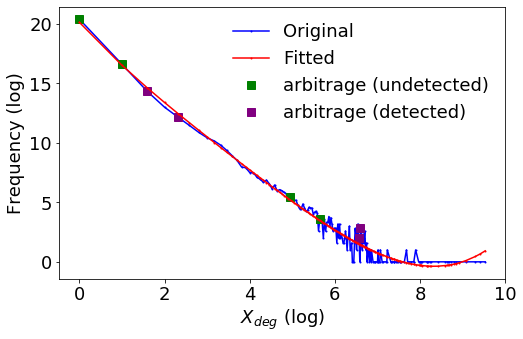

brushing :  3


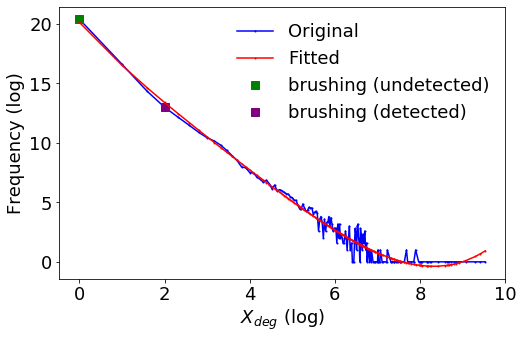

rewards :  13


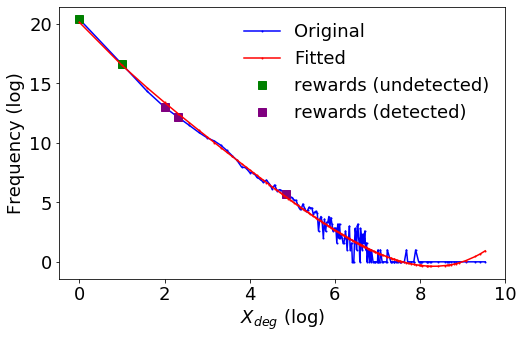

normal :  22


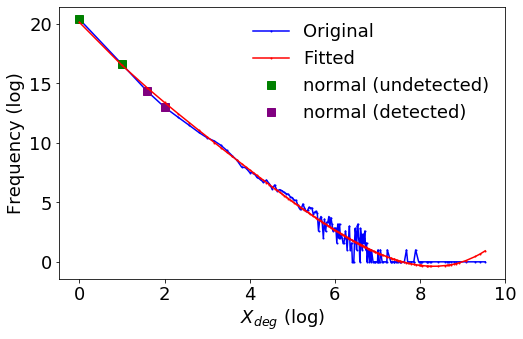

fraud :  19


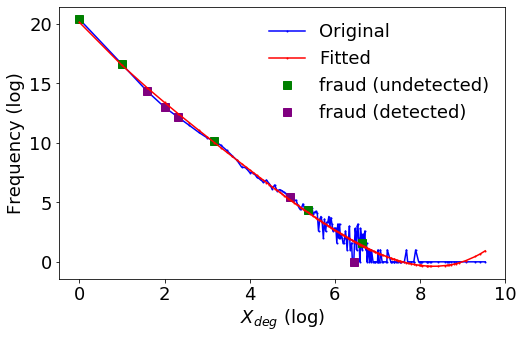

triangulation :  12


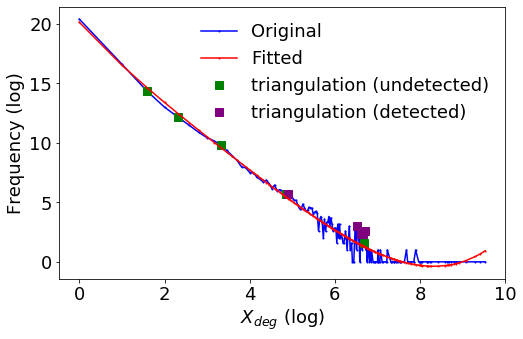

In [139]:
indegree_discrete_distr = dict(collections.OrderedDict(sorted(dict(Counter(indegree_distr)).items())))
unique_values, frequencies = list(indegree_discrete_distr.keys()), \
                                    list(indegree_discrete_distr.values())

for _comment, _cusIds in comment_2_cusIdx_dict.items():
    Xs_abn = [_indegree for _indegree, _claimer in zip(indegree_distr, claimers) if _claimer in _cusIds]

    _unique_value_2_id = dict([(_unique_value, i)for i, _unique_value in enumerate(unique_values)])
    labeled_id = [_unique_value_2_id[_x] for _x in Xs_abn]
    print(_comment, ": ", len(Xs_abn))
    draw_logSpike(unique_values, frequencies, Xs_abn, labeled_id, _comment, 'Indegree')

arbitrage :  12


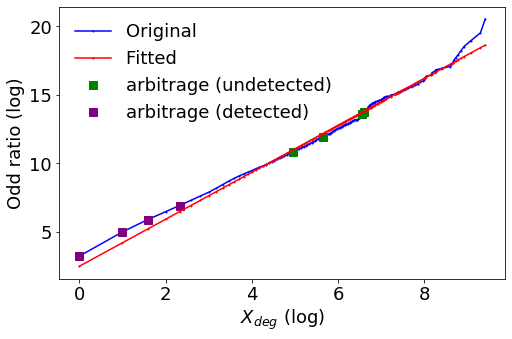

brushing :  3


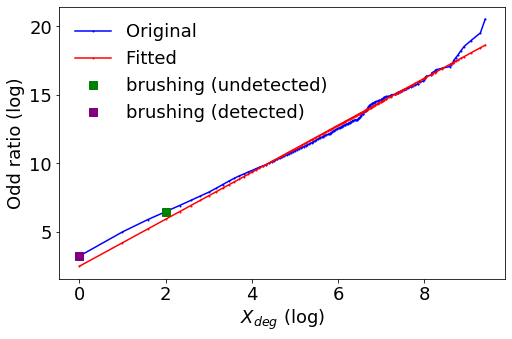

rewards :  13


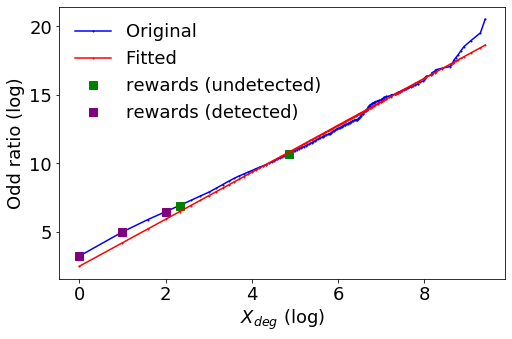

normal :  22


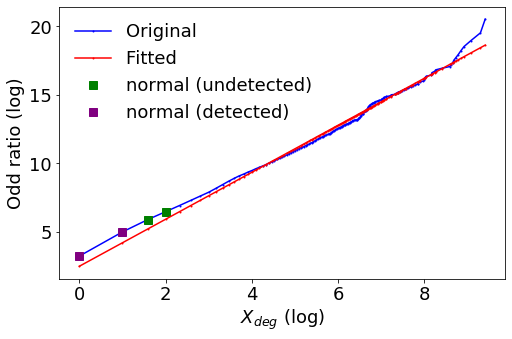

fraud :  19


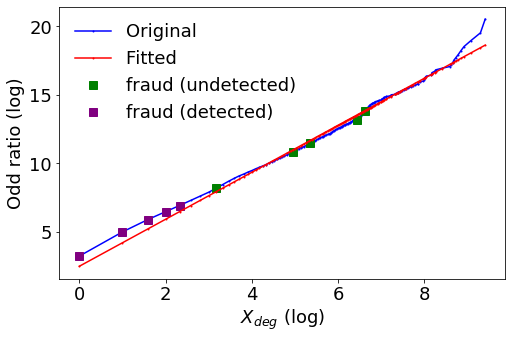

triangulation :  12


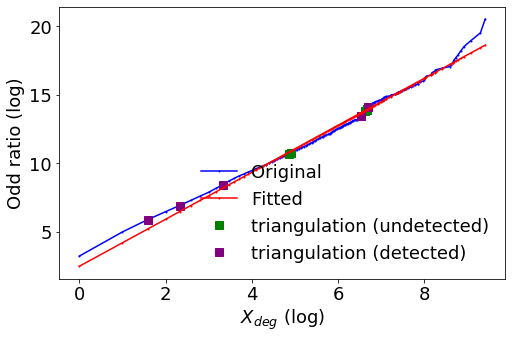

In [140]:
ux_indegree, x_indegree, y_indegree, y_fitted_indegree \
= eng.eval('powerwall(%s)'%indegree_distr, nargout=4)

ux_indegree, x_indegree, y_indegree, y_fitted_indegree \
= np.asarray(ux_indegree).flatten(), np.asarray(x_indegree).flatten(), \
np.asarray(y_indegree).flatten(), np.asarray(y_fitted_indegree).flatten()

for _comment, _cusIds in comment_2_cusIdx_dict.items():
    Xs_abn = [_indegree for _indegree, _claimer in zip(indegree_distr, claimers) if _claimer in _cusIds]

    _unique_value_2_id = dict([(_unique_value, i)for i, _unique_value in enumerate(ux_indegree)])
    labeled_id = [_unique_value_2_id[_x] for _x in Xs_abn]
    
    print(_comment, ": ", len(Xs_abn))
    draw_oddRatio(x_indegree, y_indegree, y_fitted_indegree, Xs_abn, labeled_id, _comment, 'Indegree')

###### 4.4.3 Does OPERA detect GC misuse of both givers and claimers at the same time?

In [141]:
def draw_spectralRay_explore(K, adj_mat, thrld, _category, labeled_customers_indices, metric_name):

    """
    Take on the procedure of SpectralRayFilter.

    Parameters: 
        K: the desired dimensionality of output data
        adj_mat: the adjecency matrix feeded into SVD
        thrld: the restricted threshold used to filter the points close to the origin.
    Returns: 
        the outliers released by spectralRayFilter.
    """
    
    U, Sigma, V = svd_new.svd_scipy(adj_mat, K)
    VT = np.transpose(V)

    pairs = [(u0, u1) for u0, u1 in combinations(range(K), 2)]
    
    Xs_U, Ys_U, Xs_V, Ys_V = [], [], [], []
    for u0, u1 in pairs:     
        x_U, y_U, x_V, y_V = U[:,u0], U[:,u1], VT[:,u0], VT[:,u1]
        Xs_U.append(x_U); Ys_U.append(y_U); Xs_V.append(x_V); Ys_V.append(y_V)
    Xs_U, Ys_U, Xs_V, Ys_V = np.array(Xs_U), np.array(Ys_U), np.array(Xs_V), np.array(Ys_V),
    
    markers_on = np.zeros(U.shape[0])
    for j in labeled_customers_indices:
            markers_on[j] = 1
        
    fig, axs = plt.subplots(len(pairs), 2, figsize=(25,25))
    fig.suptitle('%s'%_category)
    
    for i in np.arange(len(pairs)):
    
        p1, = axs[i, 0].plot(Xs_U[i][markers_on == 0], Ys_U[i][markers_on == 0], "o", markersize=1, color="b")
        p2, = axs[i, 0].plot(Xs_U[i][markers_on == 1], Ys_U[i][markers_on == 1], "o", markersize=8, color="r")
        p3, = axs[i, 1].plot(Xs_V[i][markers_on == 0], Ys_V[i][markers_on == 0], "o", markersize=1, color="g")
        p4, = axs[i, 1].plot(Xs_V[i][markers_on == 1], Ys_V[i][markers_on == 1], "o", markersize=8, color="r")
        
    leg1 = axs[i, 0].legend([p1, p2], ['Unlabeled customers', 'suspcious customers (labeled)'], loc=0)
    leg1.draw_frame(False)
    leg2 = axs[i, 1].legend([p3, p4], ['Unlabeled customers', 'suspcious customers (labeled)'], loc=0)
    leg2.draw_frame(False)

    for i, ax in enumerate(axs.flat):
        if i % 2 == 0:
            ax.set(xlabel="U0", ylabel="U1")
        else:
            ax.set(xlabel="V0", ylabel="V1")

    # Hide x labels and tick labels for top plots and y ticks for right plots.
#     for ax in axs.flat:
#         ax.label_outer()
#     plt.savefig('./caseStudy/spectralRay/location_in_U_V.png', dpi=1000)
    plt.show()
    plt.close()

In [142]:
def draw_spectralRay(K, adj_mat, thrld, _category, labeled_customers_indices, metric_name):

    """
    Take on the procedure of SpectralRayFilter.

    Parameters: 
        K: the desired dimensionality of output data
        adj_mat: the adjecency matrix feeded into SVD
        thrld: the restricted threshold used to filter the points close to the origin.
    Returns: 
        the outliers released by spectralRayFilter.
    """
    
    U, Sigma, V = svd_new.svd_scipy(adj_mat, K)
    VT = np.transpose(V)

    pairs = [(u0, u1) for u0, u1 in combinations(range(K), 2)]
    
    Xs_U, Ys_U, Xs_V, Ys_V = [], [], [], []
    for u0, u1 in pairs:     
        x_U, y_U, x_V, y_V = U[:,u0], U[:,u1], VT[:,u0], VT[:,u1]
        Xs_U.append(x_U); Ys_U.append(y_U); Xs_V.append(x_V); Ys_V.append(y_V)
    Xs_U, Ys_U, Xs_V, Ys_V = np.array(Xs_U), np.array(Ys_U), np.array(Xs_V), np.array(Ys_V),
    
    markers_on = np.zeros(U.shape[0])
    markers_on[labeled_customers_indices[0]] = 1
    markers_on[labeled_customers_indices[1]] = 2
     
    i = 0
    if metric_name == 'U':
        p1, = plt.plot(Xs_U[i][markers_on == 0], Ys_U[i][markers_on == 0], "o", markersize=2, color="b")
        p2, = plt.plot(Xs_U[i][markers_on == 1], Ys_U[i][markers_on == 1], "s", markersize=10, color="r")
        p3, = plt.plot(Xs_U[i][markers_on == 2], Ys_U[i][markers_on == 2], "H", markersize=12, color="g")
        plt.xlabel("U0")
        plt.ylabel("U1")
        plt.legend([p2, p3], ['One detected giver', 'One detected claimer'], loc=0)
        
    if metric_name == 'V':
        p1, = plt.plot(Xs_V[i][markers_on == 0], Ys_V[i][markers_on == 0], "o", markersize=2, color="b")
        p2, = plt.plot(Xs_V[i][markers_on == 1], Ys_V[i][markers_on == 1], "s", markersize=10, color="r")
        p3, = plt.plot(Xs_V[i][markers_on == 2], Ys_V[i][markers_on == 2], "H", markersize=12, color="g")
        plt.xlabel("V0")
        plt.ylabel("V1")
        plt.legend([p2, p3], ['One detected giver', 'One detected claimer'], loc=0)
    
    plt.savefig('./caseStudy/spectralRay/location_in_%s.png'%metric_name, dpi=1000)
    plt.show()
    plt.close()

arbitrage  (giver #, claimer #):  8 17
***  left spectral space. 


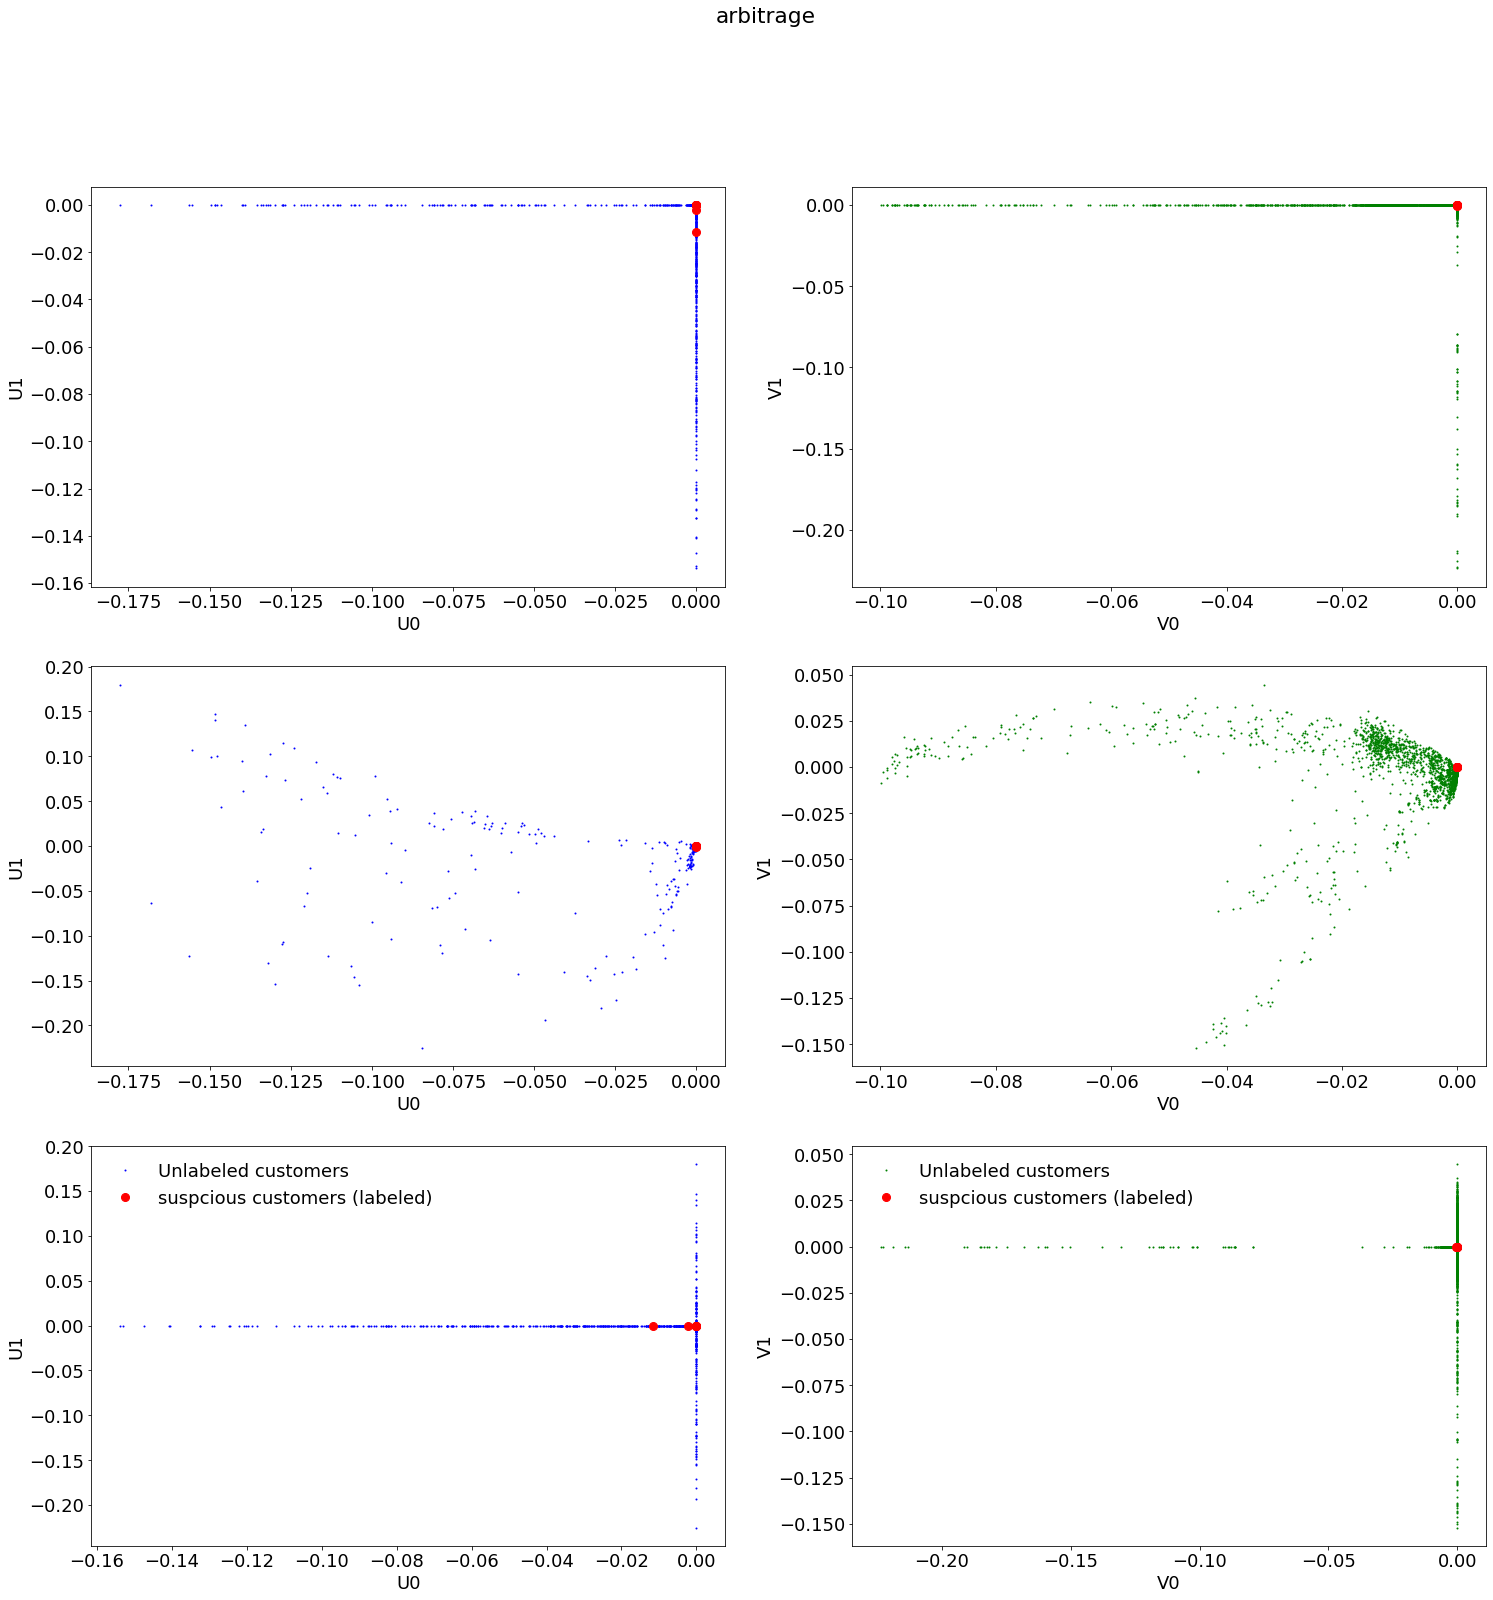

***  right spectral space. 


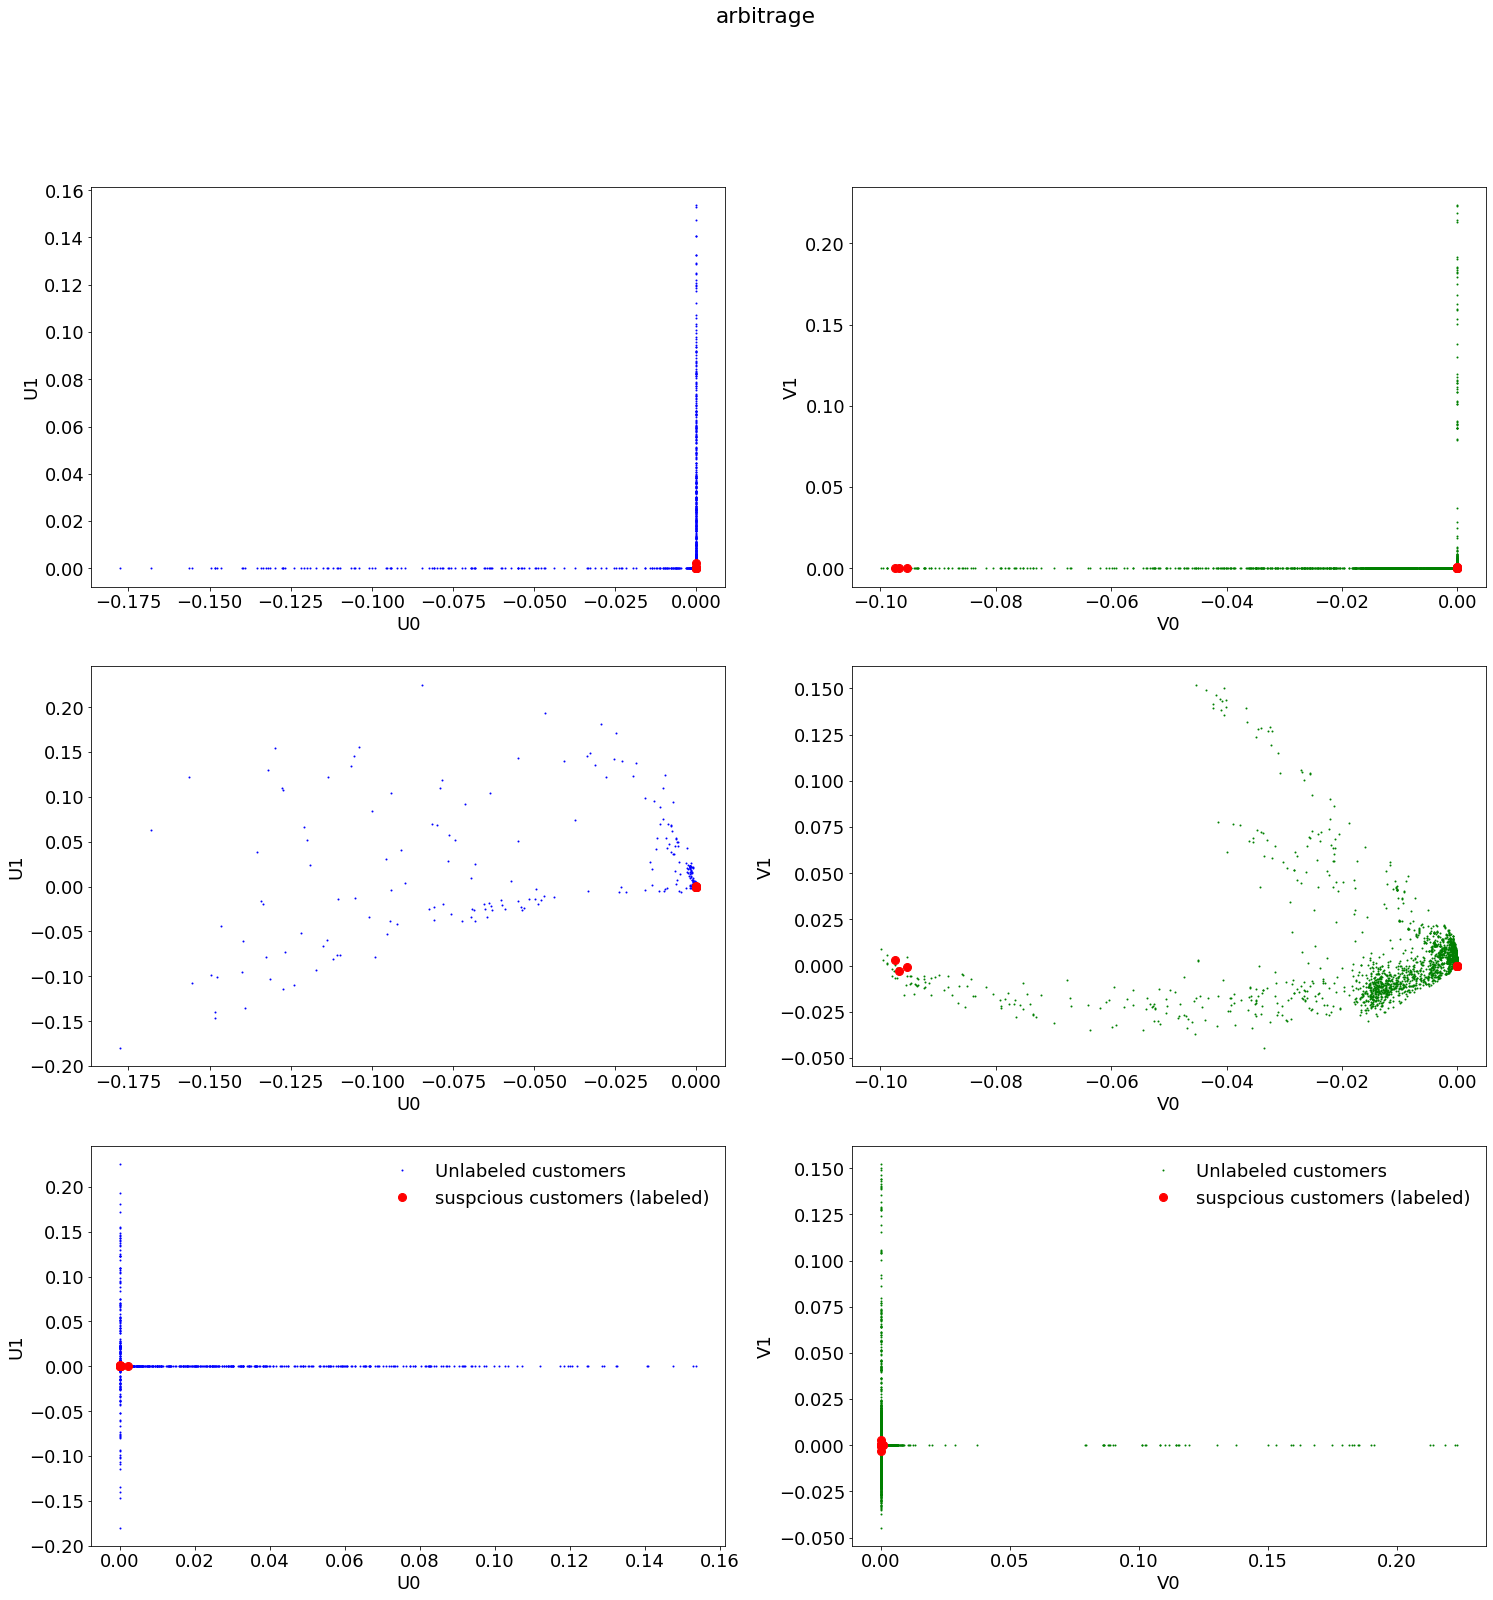

brushing  (giver #, claimer #):  9 8
***  left spectral space. 


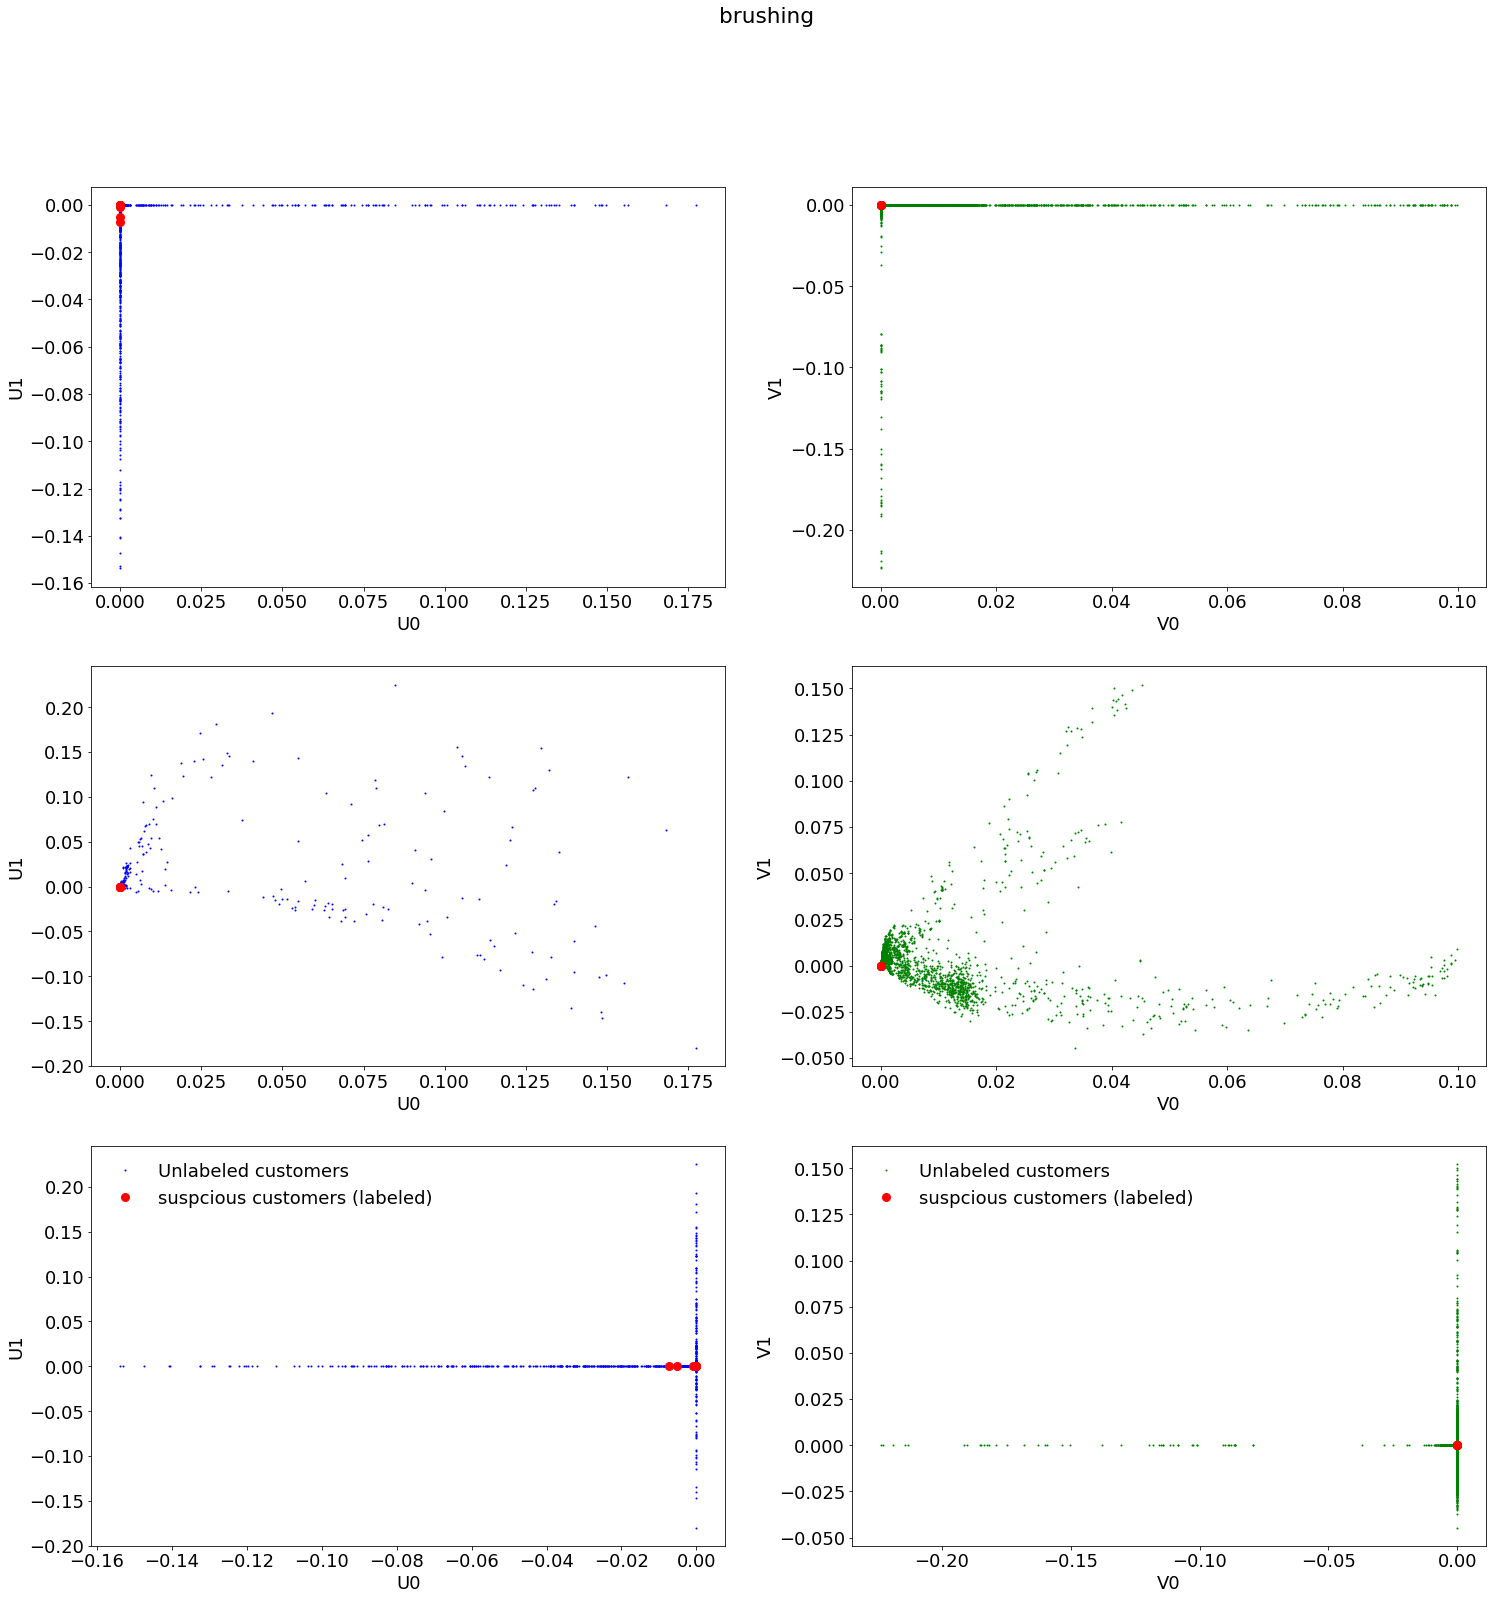

***  right spectral space. 


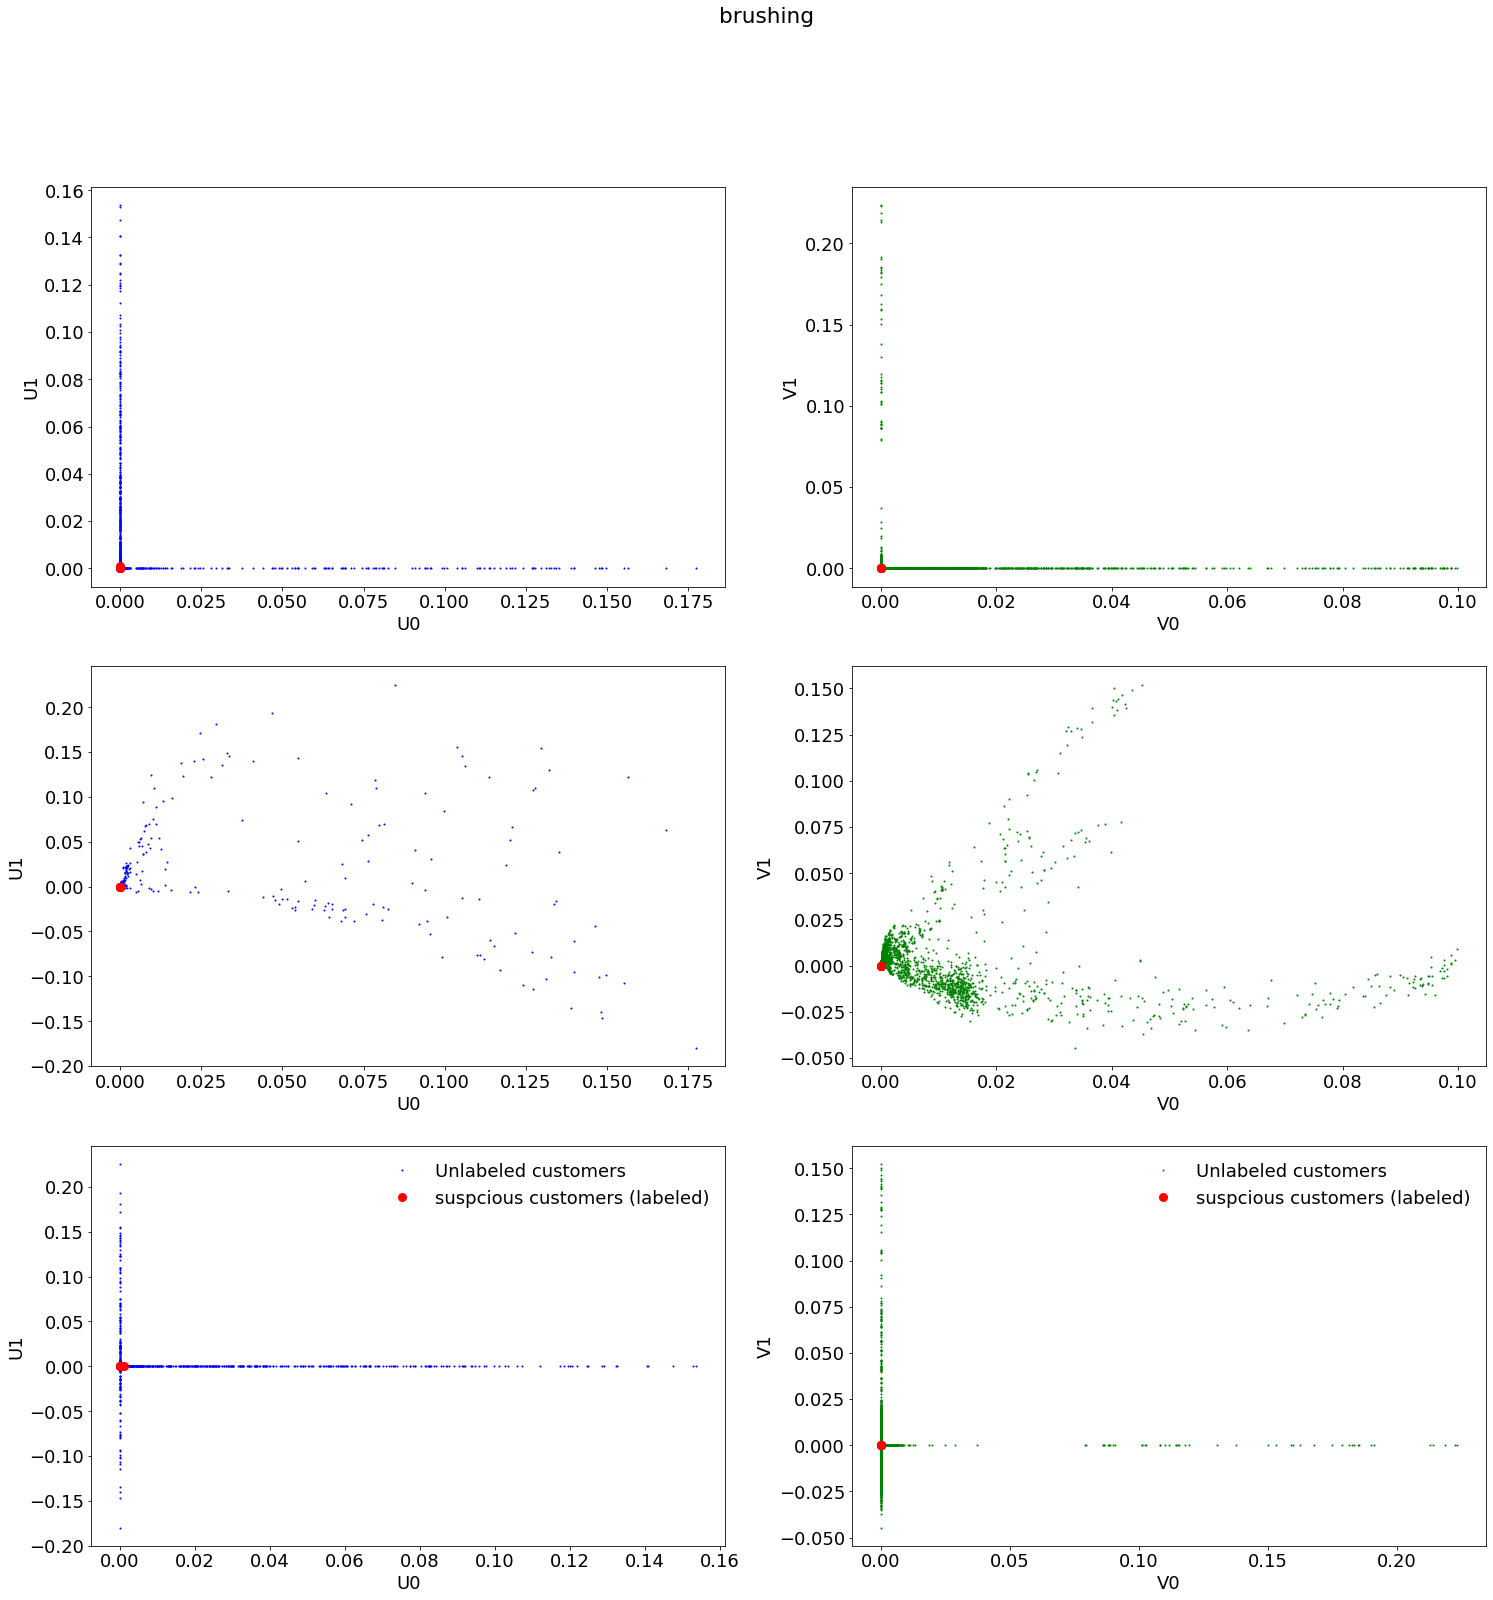

rewards  (giver #, claimer #):  48 50
***  left spectral space. 


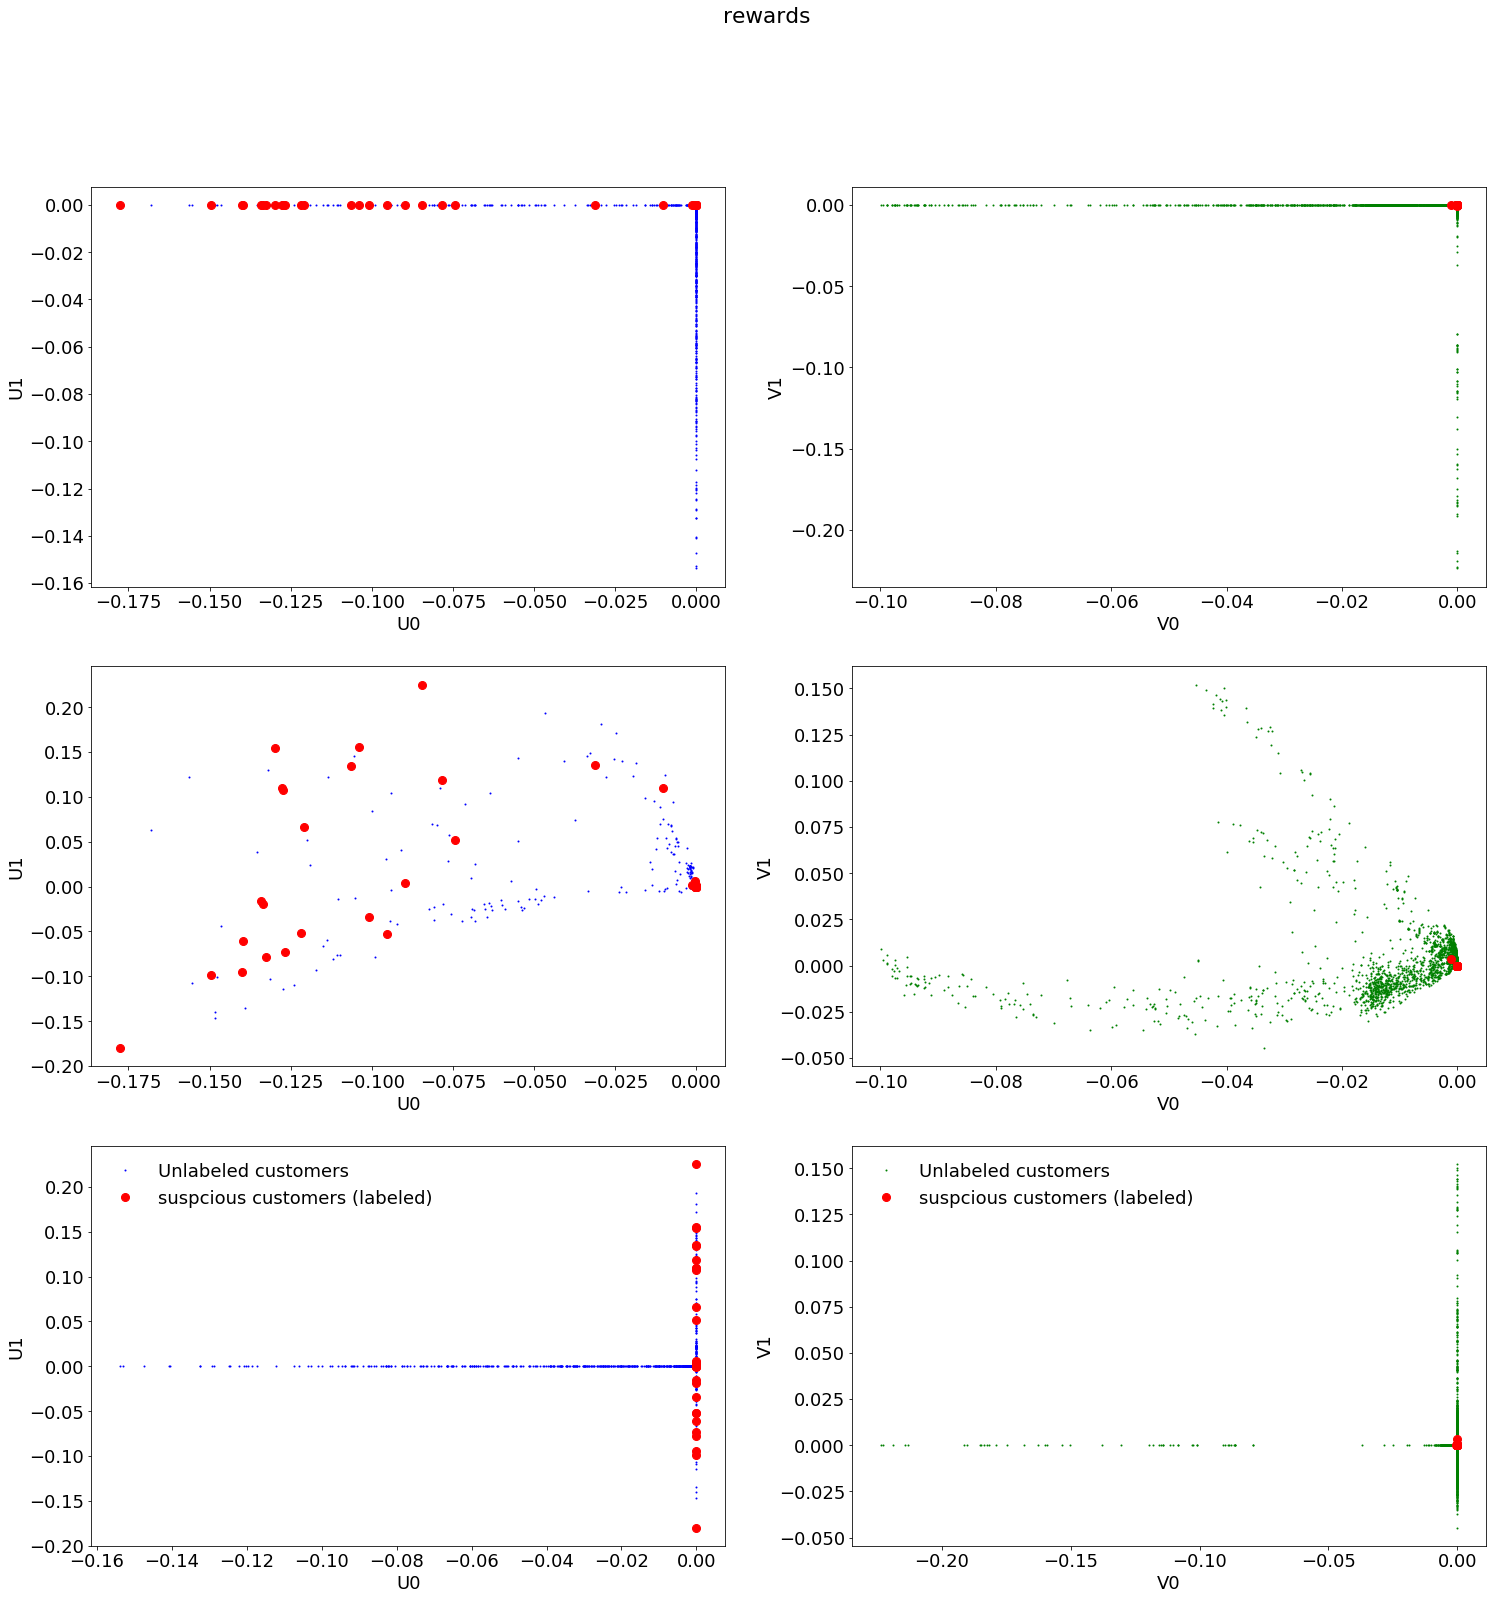

***  right spectral space. 


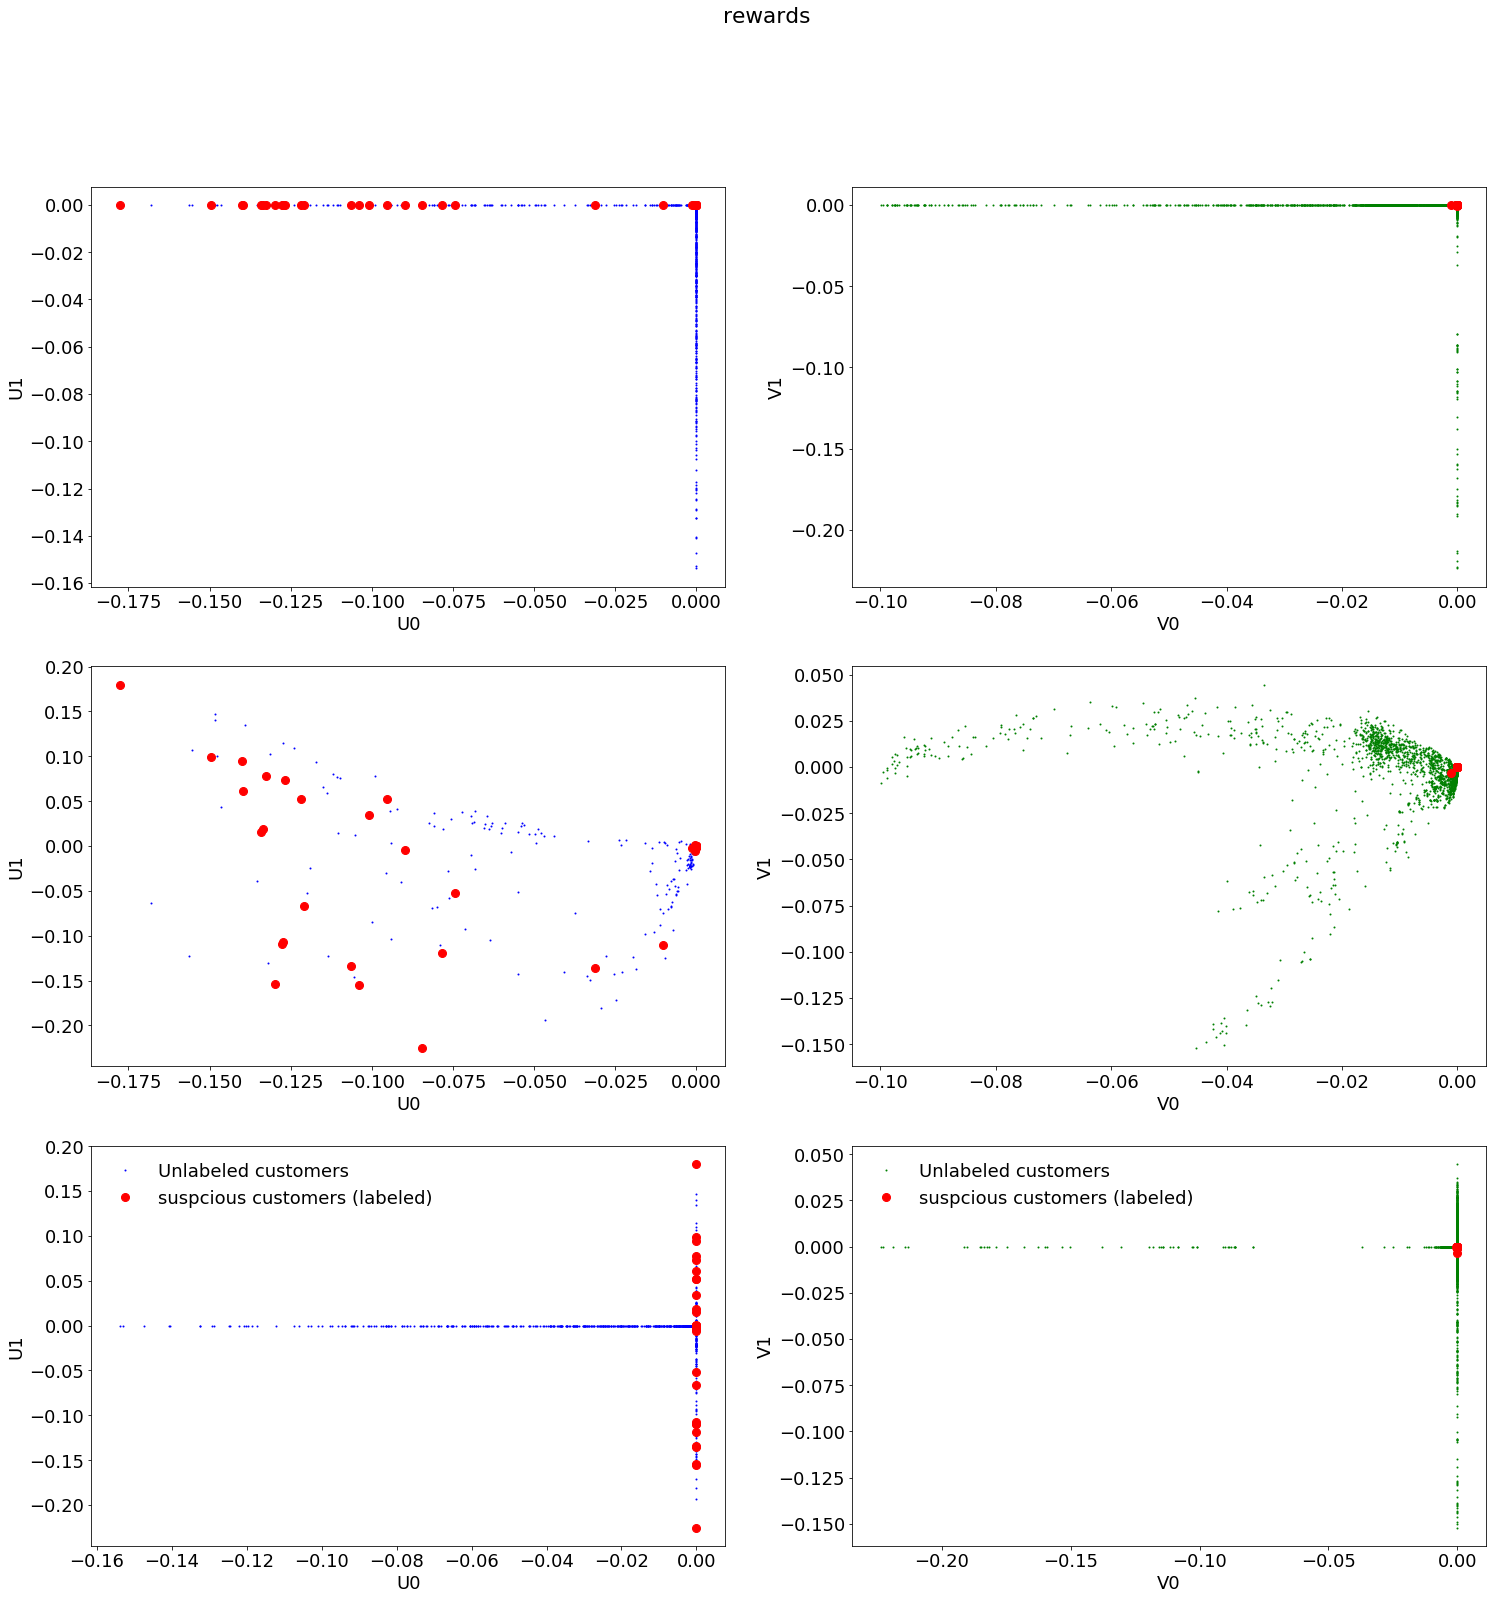

normal  (giver #, claimer #):  63 60
***  left spectral space. 


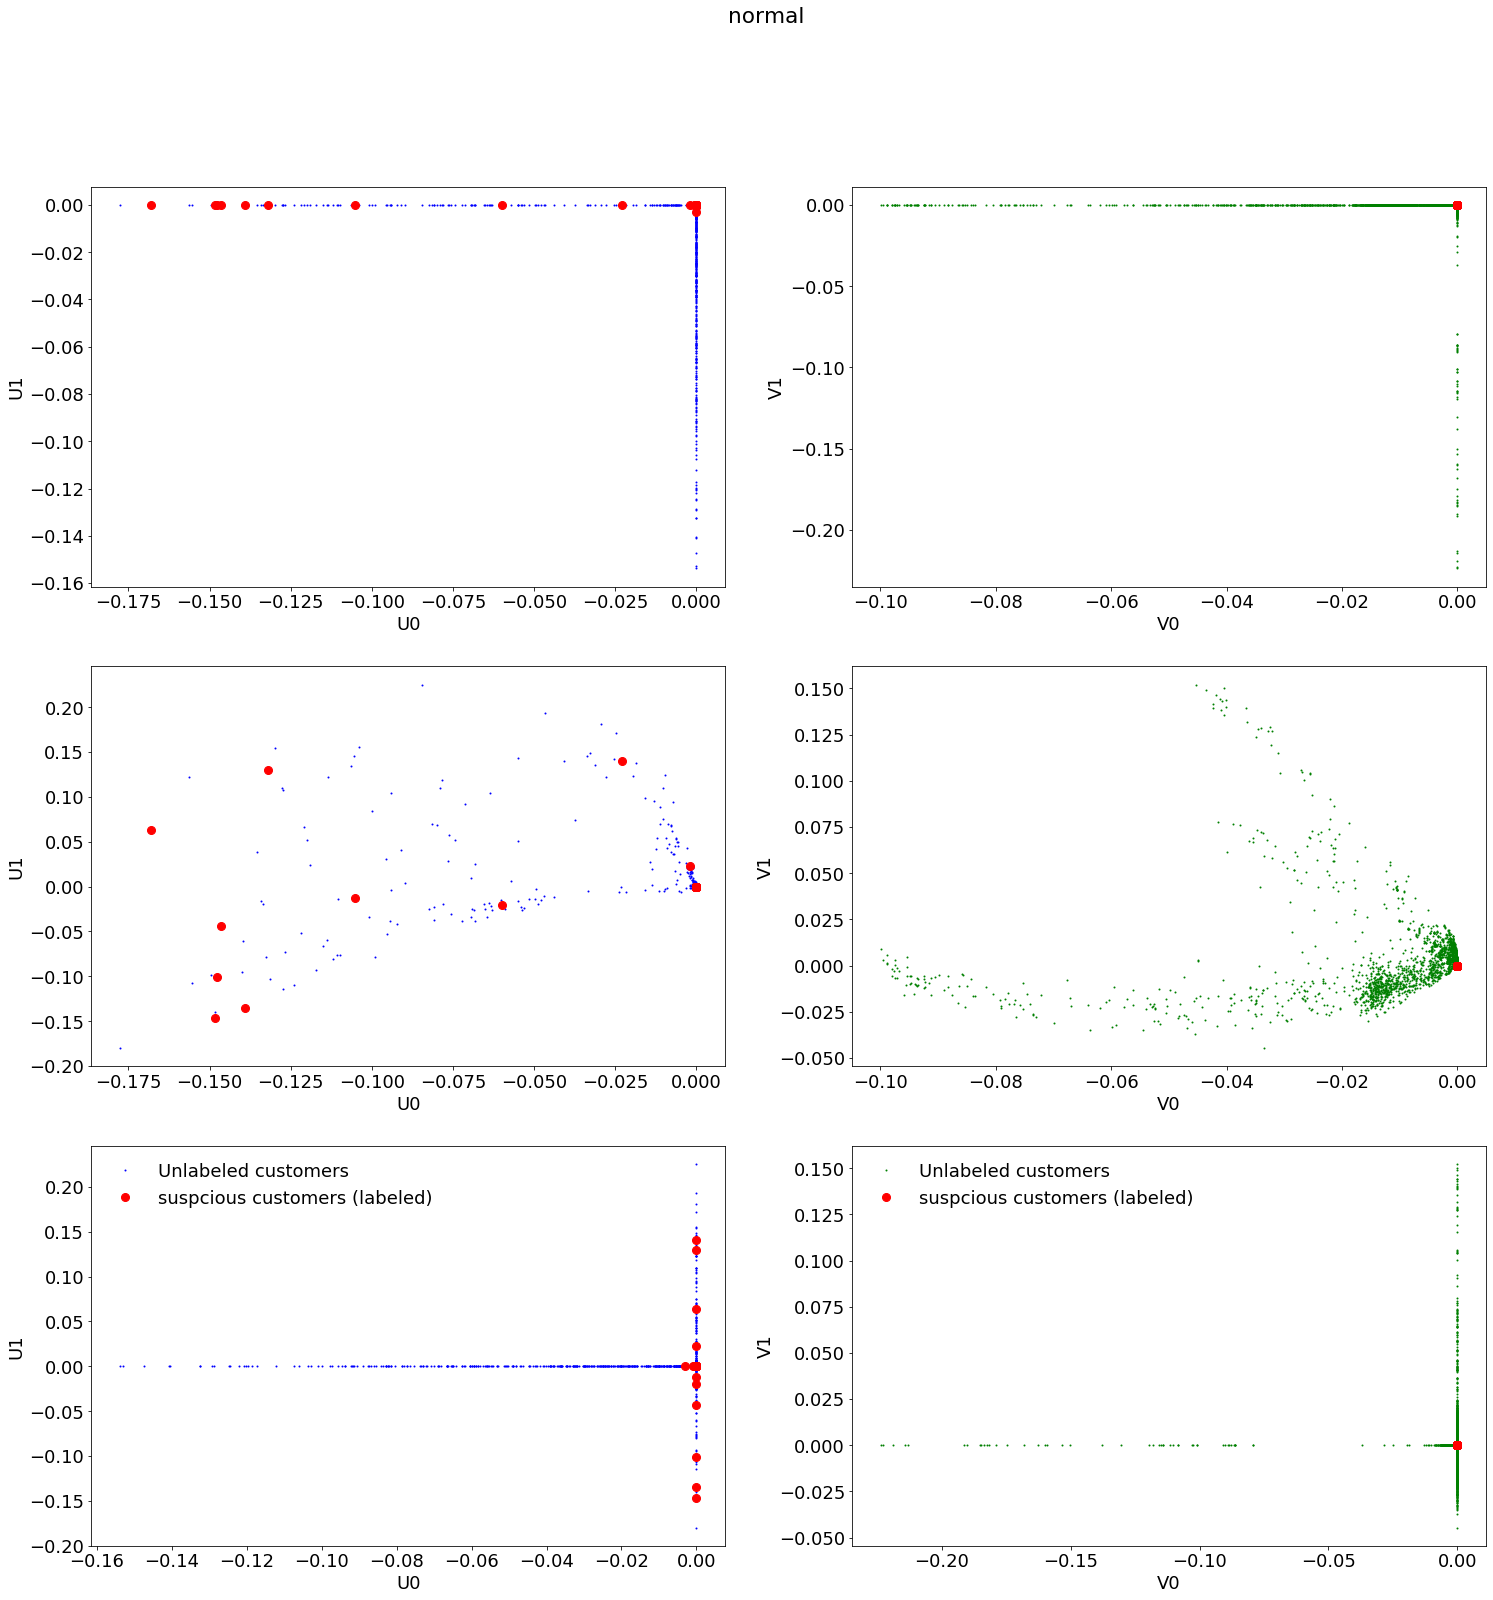

***  right spectral space. 


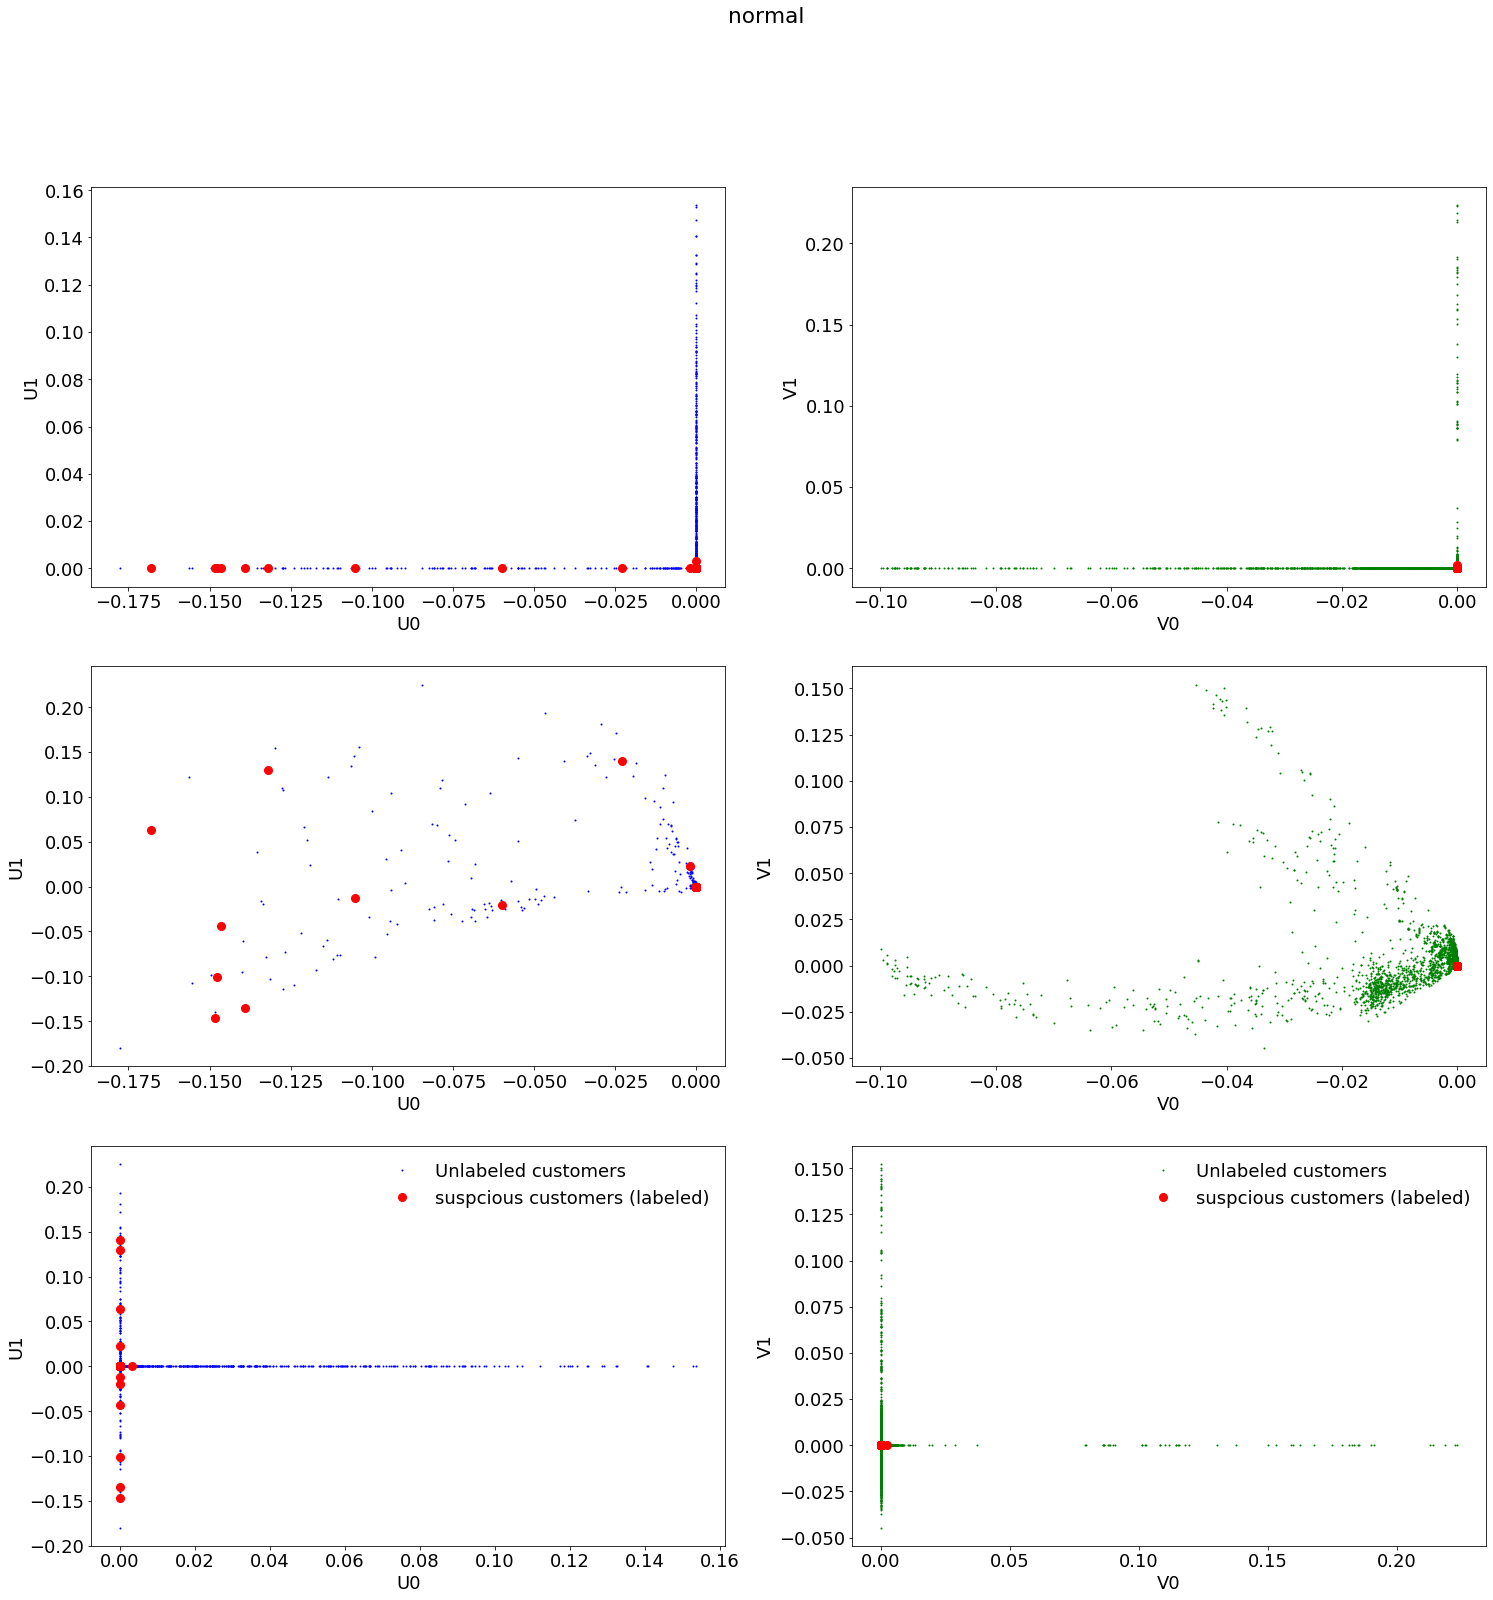

fraud  (giver #, claimer #):  5 19
***  left spectral space. 


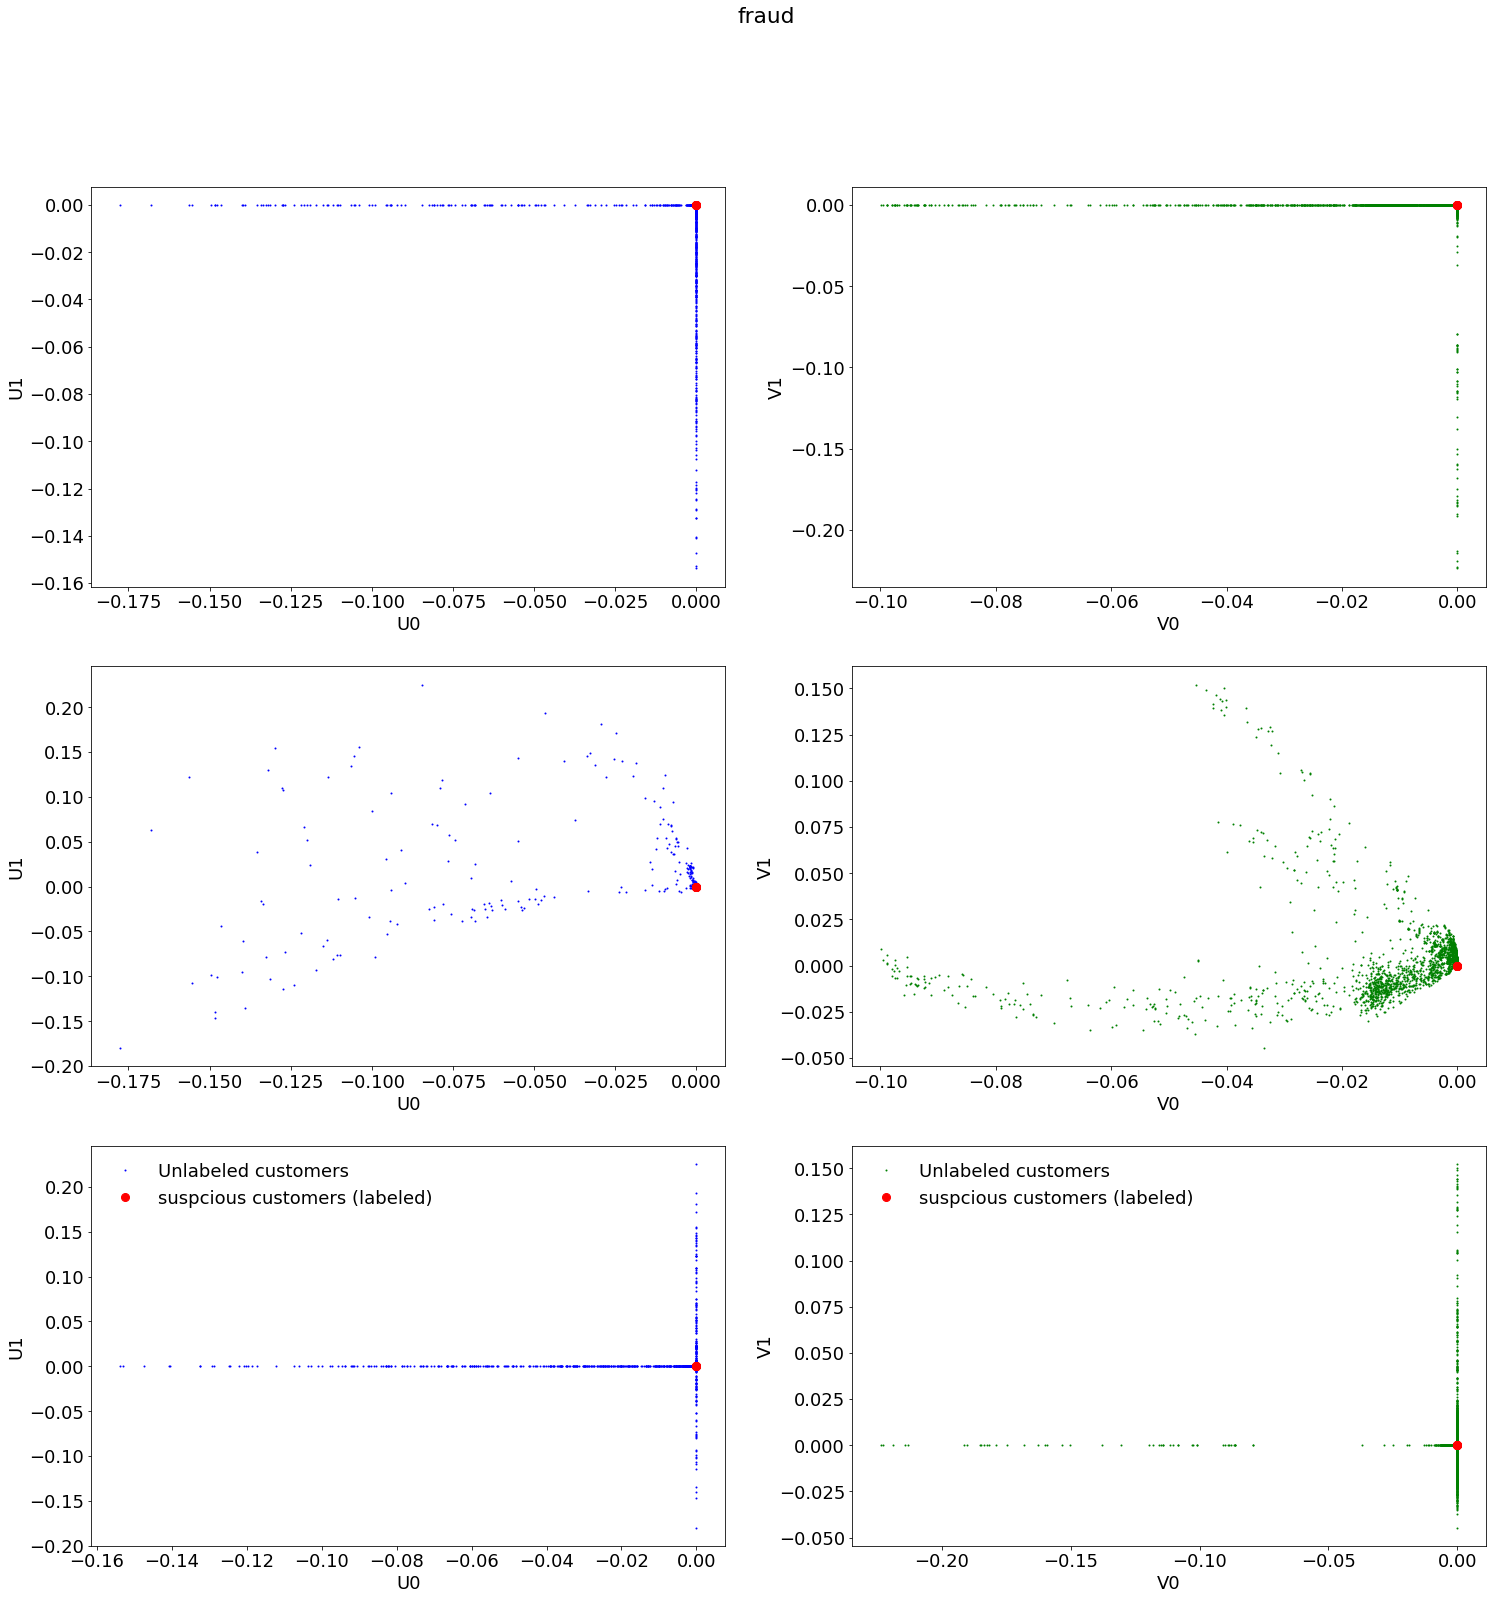

***  right spectral space. 


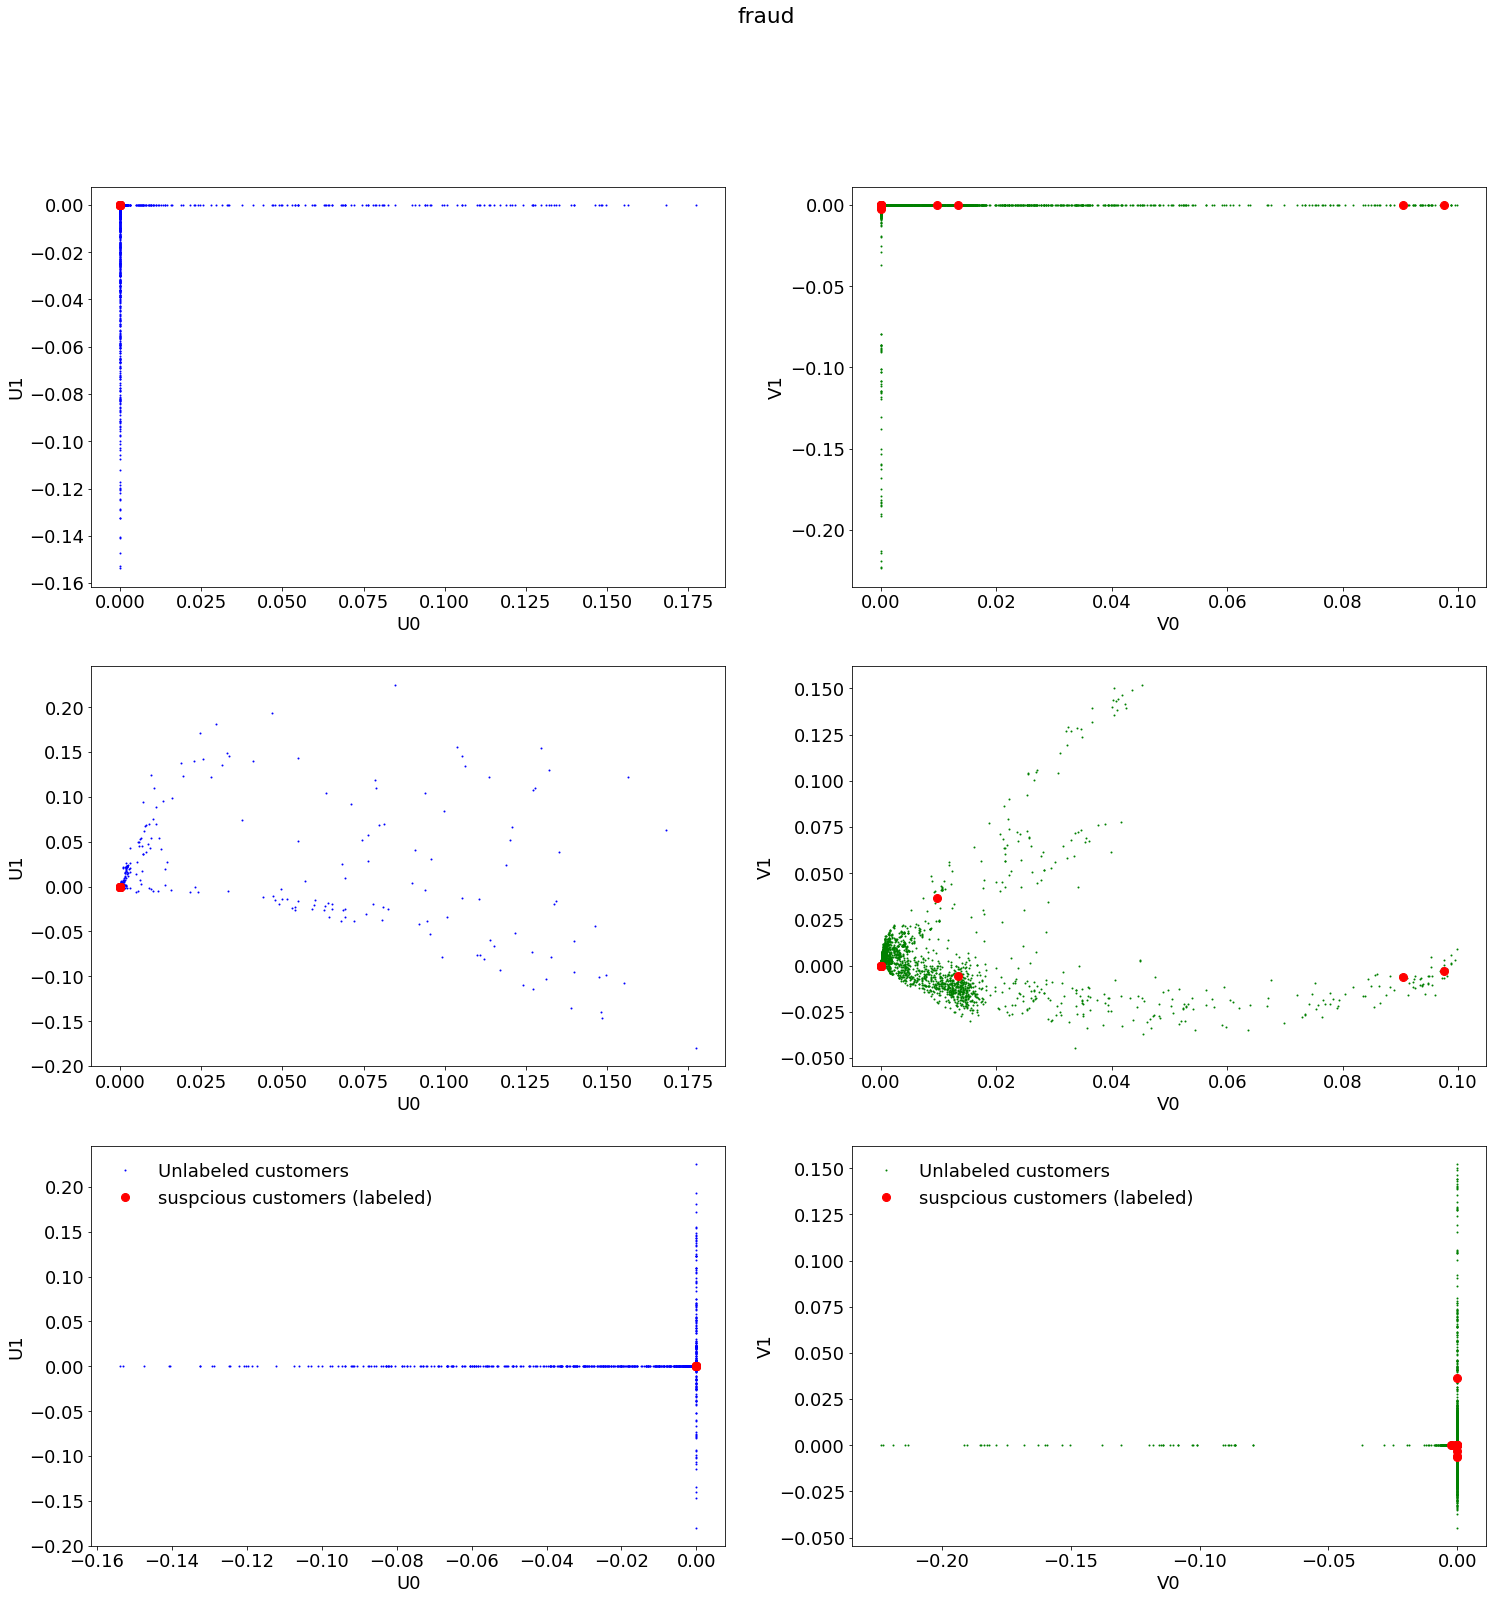

triangulation  (giver #, claimer #):  4 16
***  left spectral space. 


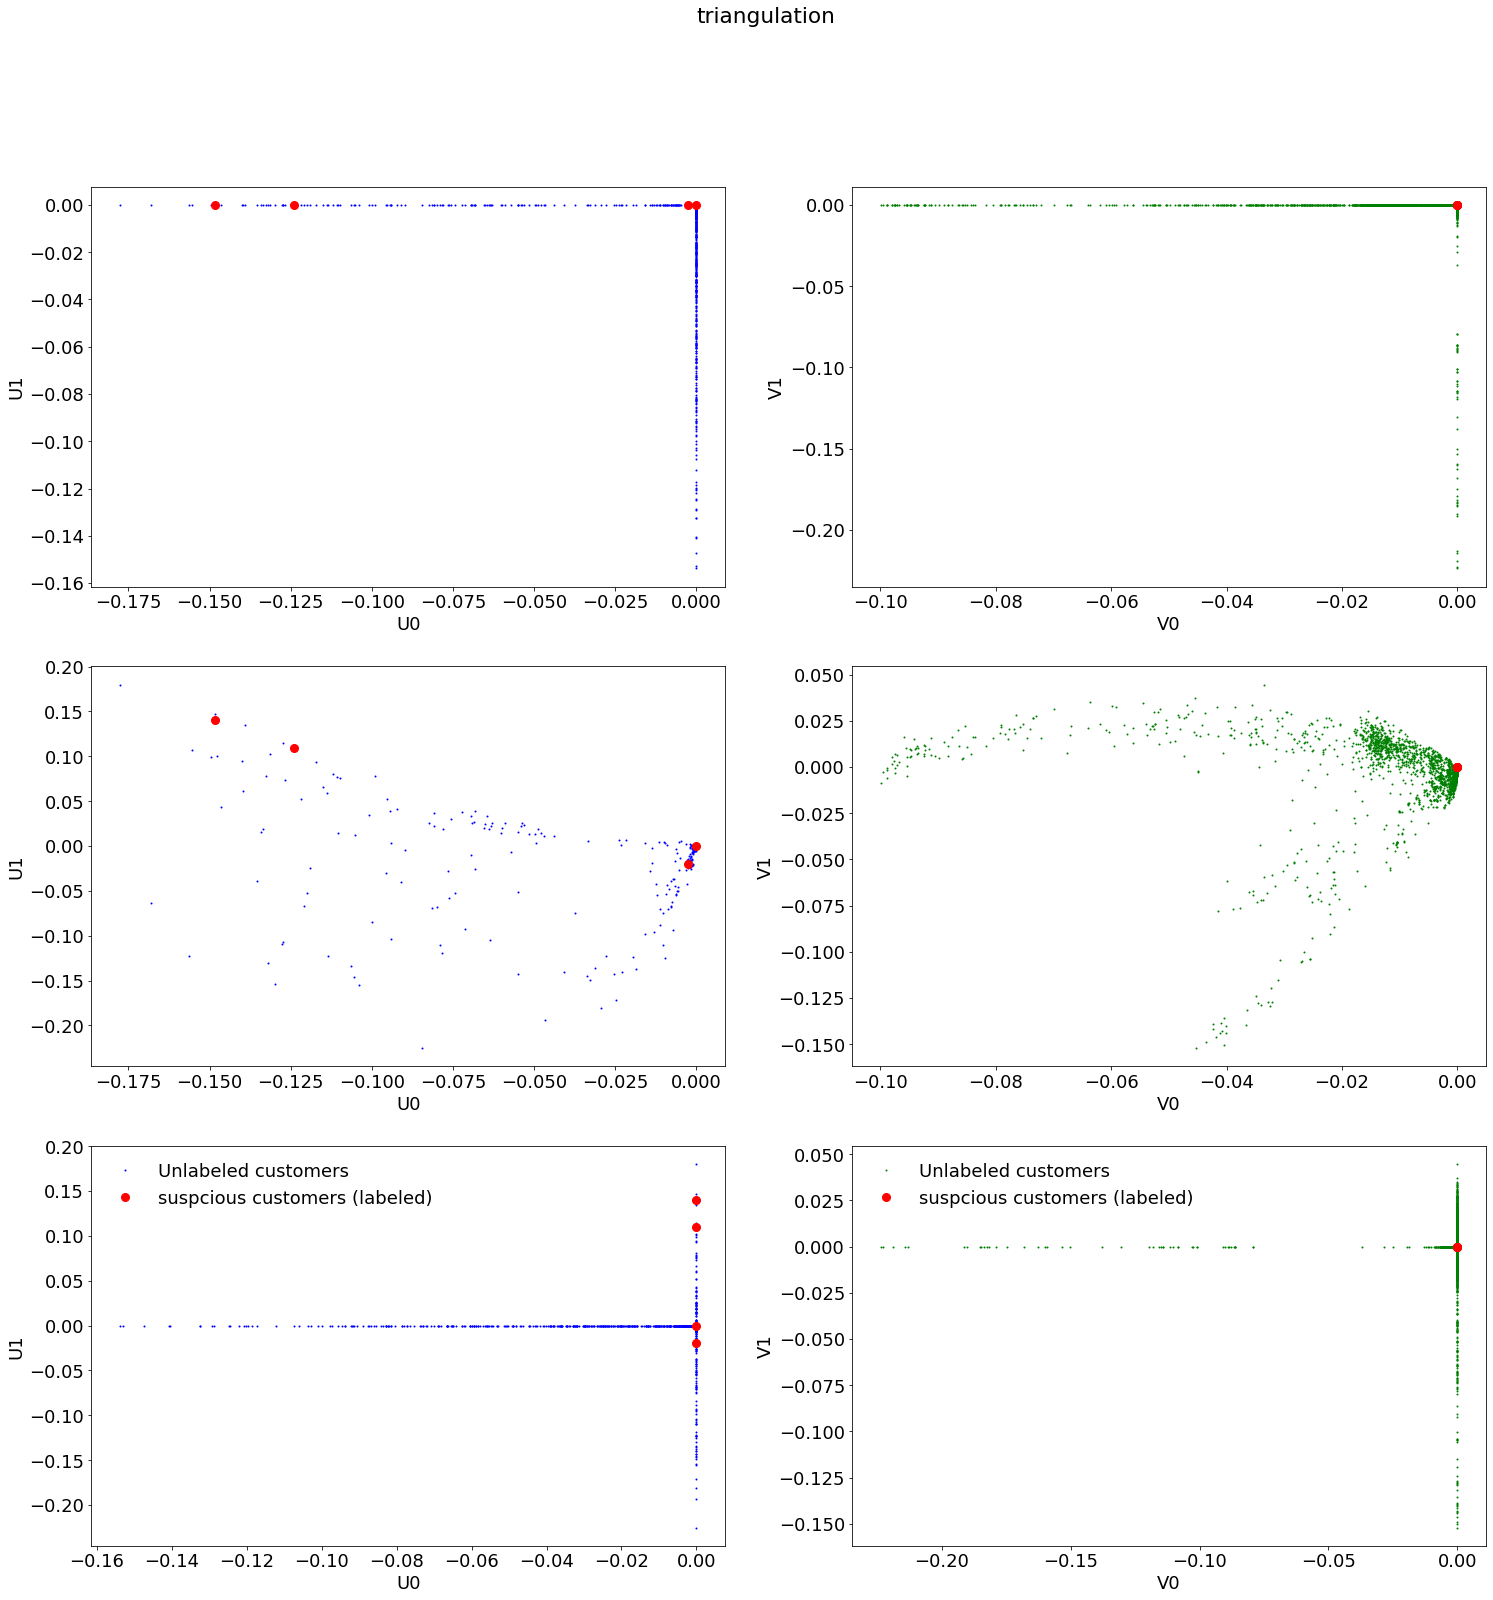

***  right spectral space. 


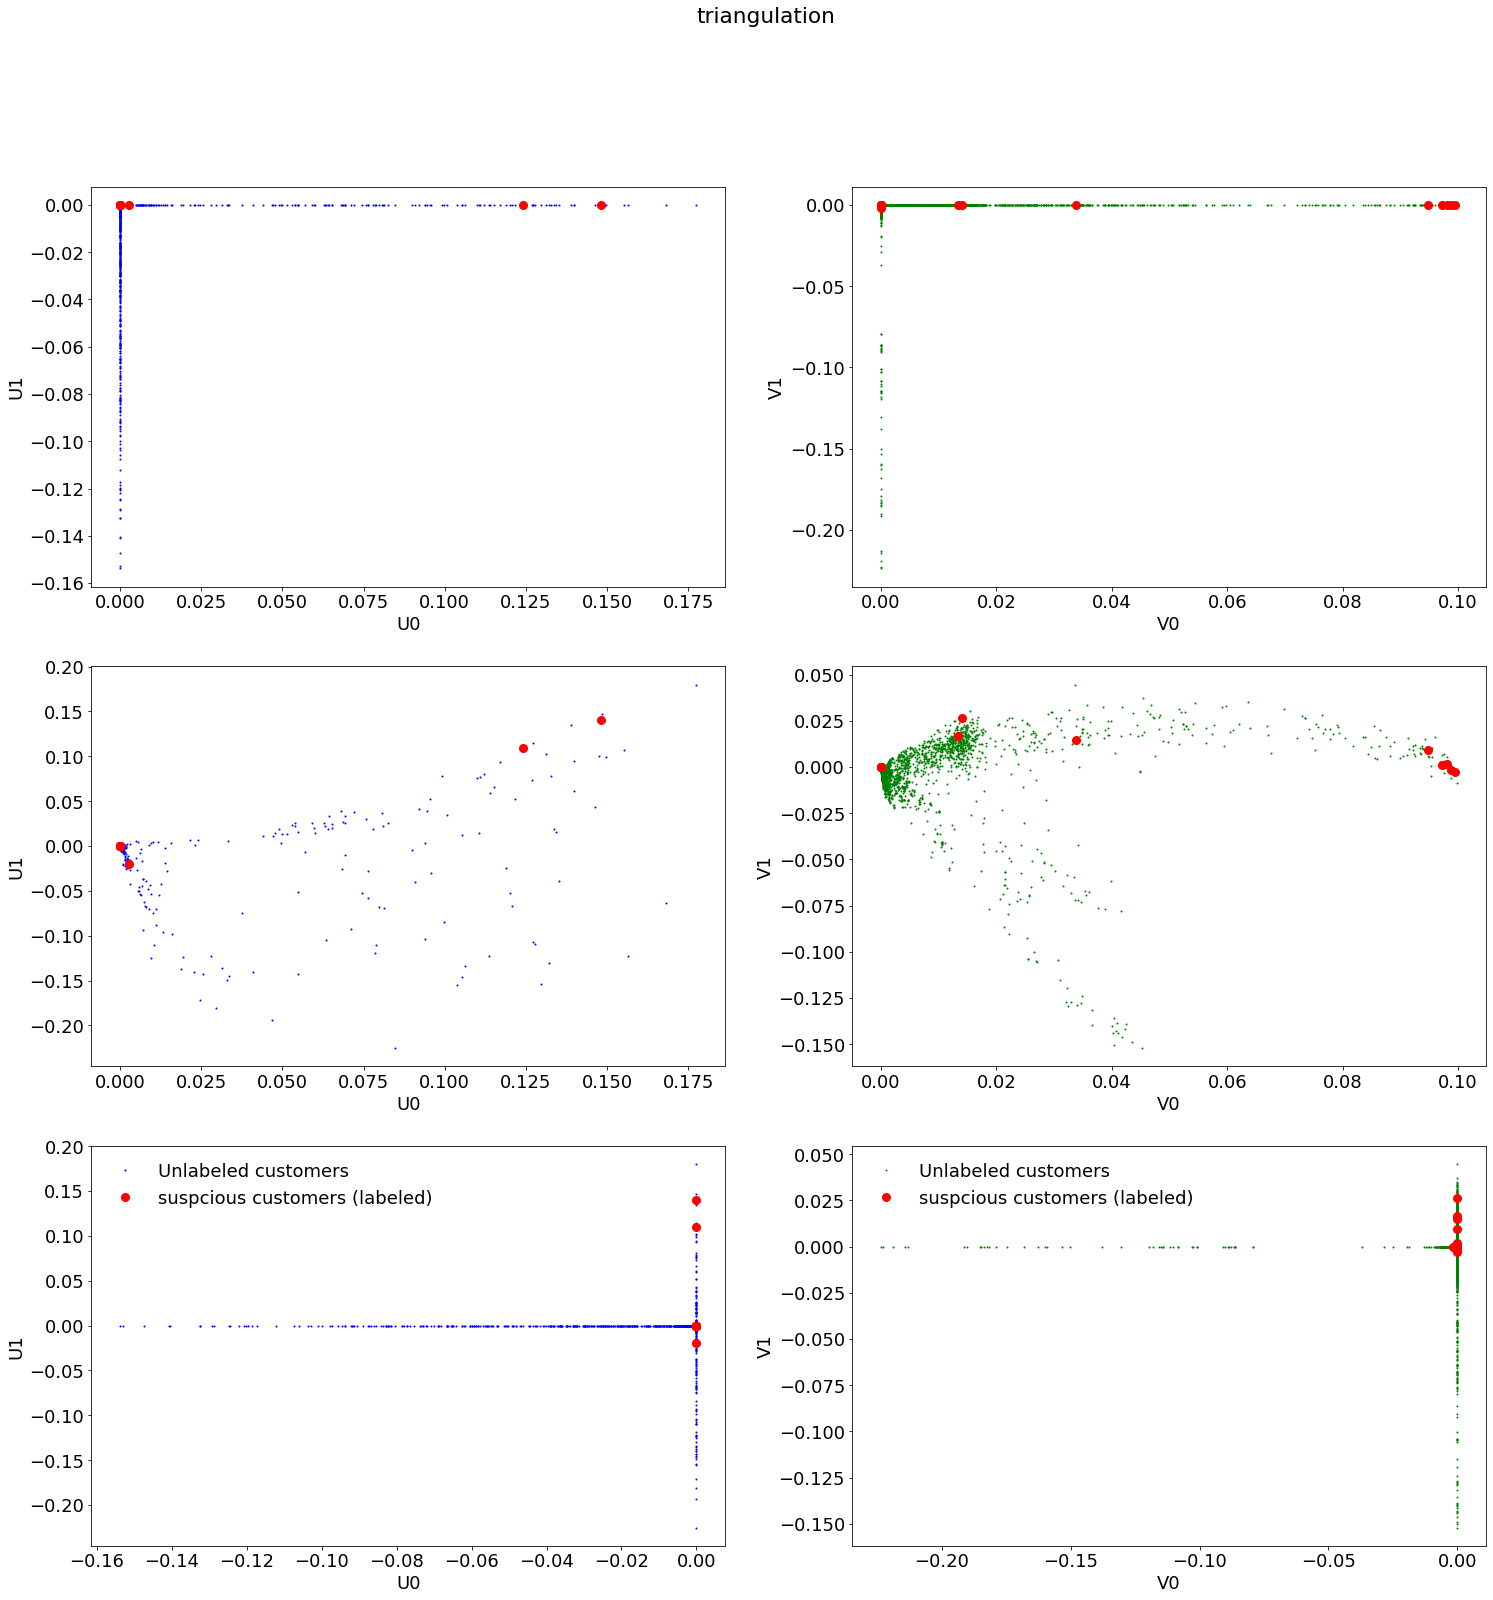

In [143]:
for _category, _cusIdices in comment_2_cusIdx_dict.items():
    _givers_cusIdx = list(set(_cusIdices).intersection(set(list(giver_2_claimer.keys()))))
    _claimers_cusIdx = list(set(_cusIdices).intersection(set(list(claimer_2_giver.keys()))))
    print(_category, " (giver #, claimer #): ", len(_givers_cusIdx), len(_claimers_cusIdx))
    print("*** ", "left spectral space. ")
    draw_spectralRay_explore(3, adj_binary_logSpike_oddRatio, 1, _category , _givers_cusIdx, 'U')
    print("*** ", "right spectral space. ")
    draw_spectralRay_explore(3, adj_binary_logSpike_oddRatio, 1, _category , _claimers_cusIdx, 'V')

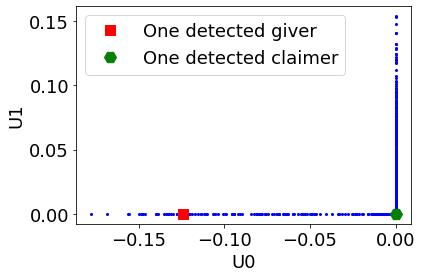

In [144]:
draw_spectralRay(3, adj_binary_logSpike_oddRatio, 1, _category , [126, 1327848], 'U')

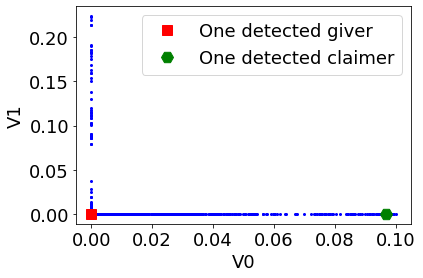

In [145]:
draw_spectralRay(3, adj_binary_logSpike_oddRatio, 1, _category , [126, 1327848], 'V')